In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suprime logs INFO e WARNING do TensorFlow
import tensorflow as tf

In [2]:
# Importar pandas
import pandas as pd

# Caminho para o arquivo de labels
labels_path = "/notebooks/RSNA_Pneumonia_512_v2_final_labels.csv"

# Carregar o arquivo de labels
labels = pd.read_csv(labels_path)

# Exibir os primeiros registros para inspeção
print("Primeiros registros do dataset original:")
print(labels.head())

# Verificar o número total de amostras antes da consolidação
print(f"\nNúmero total de amostras antes da consolidação: {len(labels)}")

# Verificar a distribuição inicial dos rótulos
print("\nDistribuição inicial dos rótulos:")
print(labels['Target'].value_counts())


Primeiros registros do dataset original:
                              patientId  Target
0  e43dfd99-e6f6-454c-9aea-ce72f2485627       0
1  f4d4d49c-57bd-45fc-92e3-bdb587005341       0
2  e6c94d90-e526-4d7d-b2bc-4a3a16c91012       0
3  fca8b18a-9851-4115-af53-6d7540820888       0
4  358ce773-7448-43c4-acac-e23992458776       0

Número total de amostras antes da consolidação: 31359

Distribuição inicial dos rótulos:
Target
0    20672
1    10687
Name: count, dtype: int64


In [3]:
# Verificar duplicatas no DataFrame completo
duplicated_rows = labels[labels.duplicated()]
print(f"Número de duplicatas no DataFrame completo: {len(duplicated_rows)}")

# Exibir as duplicatas (se houver)
if not duplicated_rows.empty:
    print("Duplicatas encontradas:")
    print(duplicated_rows)

# Verificar duplicatas apenas no patientId
duplicated_patient_ids = labels[labels['patientId'].duplicated()]
print(f"Número de duplicatas no patientId: {len(duplicated_patient_ids)}")

# Exibir duplicatas por patientId (se houver)
if not duplicated_patient_ids.empty:
    print("Duplicatas por patientId encontradas:")
    print(duplicated_patient_ids)


Número de duplicatas no DataFrame completo: 0
Número de duplicatas no patientId: 0


In [4]:
# Consolidar os rótulos por patientId
simplified_labels = labels.groupby('patientId').agg({
    'Target': 'max'  # Se qualquer Target for 1, o resultado será 1
}).reset_index()

# Exibir os primeiros registros após a consolidação
print("Primeiros registros após a consolidação:")
print(simplified_labels.head())

# Verificar o número total de amostras após a consolidação
print(f"\nNúmero total de amostras após a consolidação: {len(simplified_labels)}")

# Verificar a nova distribuição dos rótulos
print("\nDistribuição dos rótulos após a consolidação:")
print(simplified_labels['Target'].value_counts())


Primeiros registros após a consolidação:
                              patientId  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6       0
1  000924cf-0f8d-42bd-9158-1af53881a557       0
2  000db696-cf54-4385-b10b-6b16fbb3f985       1
3  000fe35a-2649-43d4-b027-e67796d412e0       1
4  001031d9-f904-4a23-b3e5-2c088acd19c6       1

Número total de amostras após a consolidação: 31359

Distribuição dos rótulos após a consolidação:
Target
0    20672
1    10687
Name: count, dtype: int64


In [5]:
import numpy as np

# Número de classes (0: Normal, 1: Pneumonia)
num_classes = 2

# Aplicar One-Hot Encoding ao campo 'Target'
simplified_labels['Target_OneHot'] = list(
    np.eye(num_classes)[simplified_labels['Target']]
)

# Exibir os primeiros registros com One-Hot Encoding
print("Primeiros registros com One-Hot Encoding:")
print(simplified_labels[['patientId', 'Target', 'Target_OneHot']].head())


Primeiros registros com One-Hot Encoding:
                              patientId  Target Target_OneHot
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6       0    [1.0, 0.0]
1  000924cf-0f8d-42bd-9158-1af53881a557       0    [1.0, 0.0]
2  000db696-cf54-4385-b10b-6b16fbb3f985       1    [0.0, 1.0]
3  000fe35a-2649-43d4-b027-e67796d412e0       1    [0.0, 1.0]
4  001031d9-f904-4a23-b3e5-2c088acd19c6       1    [0.0, 1.0]


In [6]:
import os

# Diretório base das imagens PNG organizadas por classe
png_base_dir = "/notebooks/RSNA_Pneumonia"

# Verificar se as imagens PNG existem para todos os patientIds
labels['Exists'] = labels['patientId'].apply(
    lambda x: os.path.exists(
        os.path.join(png_base_dir, 'Pneumonia', f"{x}.png")
    ) or os.path.exists(
        os.path.join(png_base_dir, 'Normal', f"{x}.png")
    )
)

# Filtrar os IDs que não têm uma imagem correspondente
missing_images = labels[~labels['Exists']]
print(f"Imagens ausentes (em PNG): {len(missing_images)}")

# Exibir os IDs das imagens ausentes (se houver)
if not missing_images.empty:
    print("IDs das imagens ausentes:")
    print(missing_images[['patientId', 'Target']])


Imagens ausentes (em PNG): 0


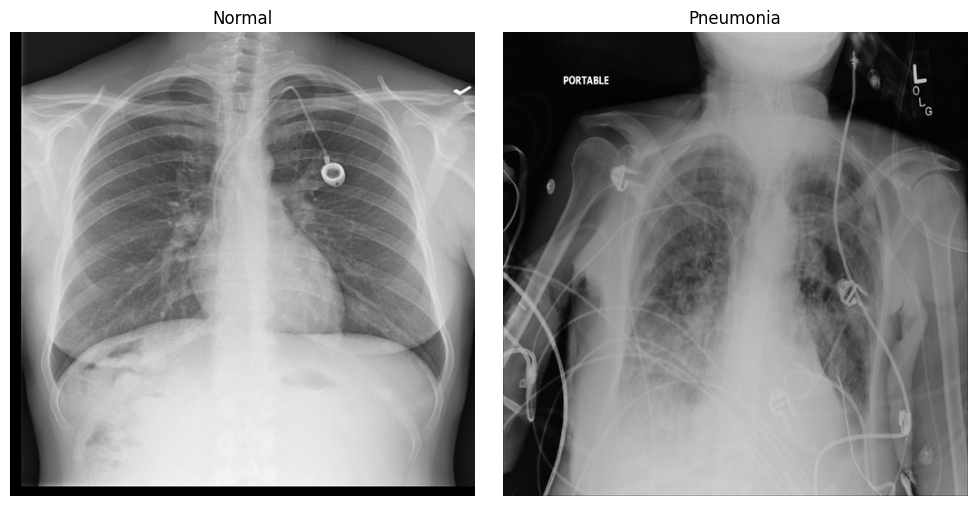

In [7]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Diretórios das pastas
normal_dir = "/notebooks/RSNA_Pneumonia/Normal"
pneumonia_dir = "/notebooks/RSNA_Pneumonia/Pneumonia"

# Criar uma lista com as pastas e seus nomes
folders = [
    {'name': 'Normal', 'path': normal_dir},
    {'name': 'Pneumonia', 'path': pneumonia_dir}
]

# Criar um gráfico para mostrar uma imagem de cada pasta
plt.figure(figsize=(10, 5))

for i, folder in enumerate(folders):
    # Pegar o primeiro arquivo PNG da pasta
    image_file = next((f for f in os.listdir(folder['path']) if f.endswith('.png')), None)

    if image_file:  # Se houver uma imagem na pasta
        image_path = os.path.join(folder['path'], image_file)
        img = Image.open(image_path)

        # Mostrar a imagem
        plt.subplot(1, len(folders), i + 1)
        plt.imshow(img)
        plt.title(folder['name'])
        plt.axis('off')

plt.tight_layout()
plt.show()


In [8]:
#1. Distribuição das Classes
import os

# Diretórios das classes
normal_dir = "/notebooks/RSNA_Pneumonia/Normal"
pneumonia_dir = "/notebooks/RSNA_Pneumonia/Pneumonia"

# Contar o número de imagens em cada pasta
normal_count = len([f for f in os.listdir(normal_dir) if f.endswith('.png')])
pneumonia_count = len([f for f in os.listdir(pneumonia_dir) if f.endswith('.png')])

# Exibir a distribuição
print("Distribuição das classes:")
print(f"Normal: {normal_count}")
print(f"Pneumonia: {pneumonia_count}")

Distribuição das classes:
Normal: 20672
Pneumonia: 10687


#2. Dimensões das Imagens
from PIL import Image

# Verificar dimensões das imagens
def get_image_dimensions(directory):
    dimensions = []
    for file in os.listdir(directory):
        if file.endswith('.png'):
            img = Image.open(os.path.join(directory, file))
            dimensions.append(img.size)
    return dimensions

# Dimensões para cada classe
normal_dims = get_image_dimensions(normal_dir)
pneumonia_dims = get_image_dimensions(pneumonia_dir)

# Exibir alguns exemplos
print("\nDimensões das imagens (Normal):")
print(normal_dims[:5])
print("\nDimensões das imagens (Pneumonia):")
print(pneumonia_dims[:5])


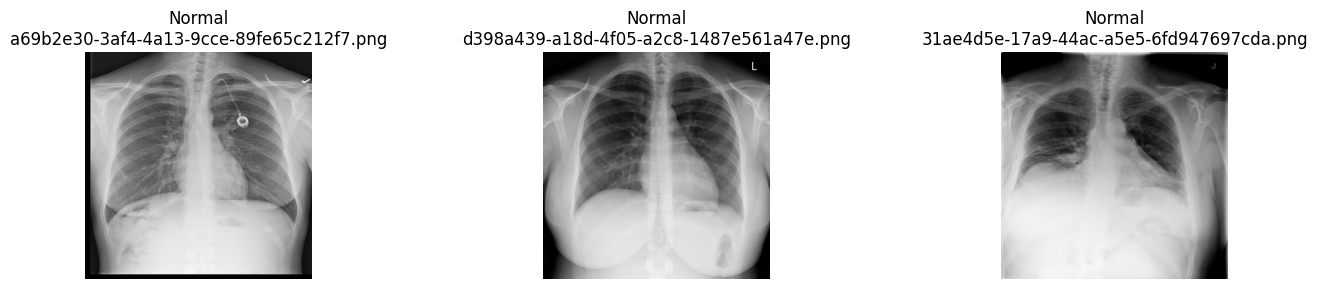

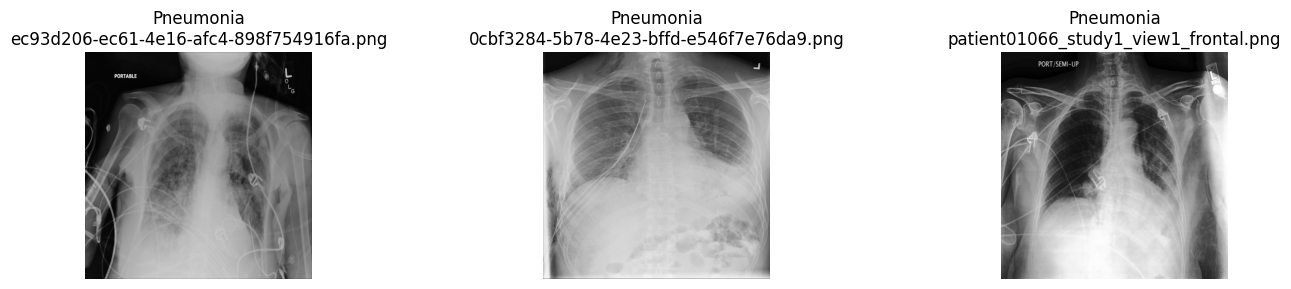

In [9]:
# 3. Análise Visual
import matplotlib.pyplot as plt
from PIL import Image

# Visualizar algumas imagens
def show_images(directory, title, num_images=3):
    plt.figure(figsize=(15, 3))
    files = [f for f in os.listdir(directory) if f.endswith('.png')][:num_images]
    for i, file in enumerate(files):
        img = Image.open(os.path.join(directory, file))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{title}\n{file}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualizar imagens de ambas as classes
show_images(normal_dir, "Normal")
show_images(pneumonia_dir, "Pneumonia")


In [10]:
# Verificar o tamanho médio dos arquivos em cada classe
def get_average_file_size(directory):
    file_sizes = [os.path.getsize(os.path.join(directory, f)) for f in os.listdir(directory) if f.endswith('.png')]
    return sum(file_sizes) / len(file_sizes)

normal_avg_size = get_average_file_size(normal_dir)
pneumonia_avg_size = get_average_file_size(pneumonia_dir)

print("\nTamanho médio dos arquivos:")
print(f"Normal: {normal_avg_size / 1024:.2f} KB")
print(f"Pneumonia: {pneumonia_avg_size / 1024:.2f} KB")



Tamanho médio dos arquivos:
Normal: 169.67 KB
Pneumonia: 189.55 KB


In [11]:
import random
import numpy as np
from PIL import Image

# Diretórios das classes
normal_dir = "/notebooks/RSNA_Pneumonia/Normal"
pneumonia_dir = "/notebooks/RSNA_Pneumonia/Pneumonia"

# Amostra aleatória de arquivos
sample_size = 50  # Ajuste o tamanho da amostra conforme necessário
normal_files = random.sample([f for f in os.listdir(normal_dir) if f.endswith('.png')], min(sample_size, len(os.listdir(normal_dir))))
pneumonia_files = random.sample([f for f in os.listdir(pneumonia_dir) if f.endswith('.png')], min(sample_size, len(os.listdir(pneumonia_dir))))

# Função para calcular estatísticas de pixel
def calculate_pixel_stats(files, directory):
    all_pixels = []
    for file in files:
        img = Image.open(os.path.join(directory, file)).convert('L')  # Converter para escala de cinza
        all_pixels.append(np.array(img).flatten())
    all_pixels = np.concatenate(all_pixels)
    return {
        'min': np.min(all_pixels),
        'max': np.max(all_pixels),
        'mean': np.mean(all_pixels),
        'std': np.std(all_pixels)
    }

# Calcular estatísticas para cada classe
normal_pixel_stats = calculate_pixel_stats(normal_files, normal_dir)
pneumonia_pixel_stats = calculate_pixel_stats(pneumonia_files, pneumonia_dir)

print("\nEstatísticas dos pixels (Normal):")
print(normal_pixel_stats)

print("\nEstatísticas dos pixels (Pneumonia):")
print(pneumonia_pixel_stats)




Estatísticas dos pixels (Normal):
{'min': 0, 'max': 255, 'mean': 129.31815475463867, 'std': 63.55821417516843}

Estatísticas dos pixels (Pneumonia):
{'min': 0, 'max': 255, 'mean': 128.0445319366455, 'std': 67.58602639196272}


In [12]:
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd
import numpy as np

# Dados de entrada
X = simplified_labels['patientId']
y = np.array(simplified_labels['Target_OneHot'].tolist())  # Converter Target_OneHot para um array NumPy
groups = simplified_labels['patientId']  # Garantir que imagens do mesmo paciente fiquem no mesmo conjunto

# Configurar o GroupShuffleSplit com proporção 80/20 para treino/validação
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Realizar o split
train_idx, val_idx = next(gss.split(X, y, groups=groups))

# Criar DataFrames para treino e validação
train_data = simplified_labels.iloc[train_idx].reset_index(drop=True)
val_data = simplified_labels.iloc[val_idx].reset_index(drop=True)

# Separar os rótulos no formato One-Hot
y_train = y[train_idx]
y_val = y[val_idx]

# Verificar os tamanhos dos conjuntos
print(f"Tamanho do conjunto de treino: {len(train_data)}")
print(f"Tamanho do conjunto de validação: {len(val_data)}")

print("\nDistribuição no treino:")
print(train_data['Target'].value_counts(normalize=True))

print("\nDistribuição na validação:")
print(val_data['Target'].value_counts(normalize=True))



Tamanho do conjunto de treino: 25087
Tamanho do conjunto de validação: 6272

Distribuição no treino:
Target
0    0.657592
1    0.342408
Name: proportion, dtype: float64

Distribuição na validação:
Target
0    0.665657
1    0.334343
Name: proportion, dtype: float64


In [13]:
import numpy as np

# Função para verificar a distribuição das classes em um conjunto de dados One-Hot Encoded
def check_distribution(y_set, set_name):
    # Somar as colunas para contar as ocorrências de cada classe
    class_counts = np.sum(y_set, axis=0)
    total_samples = len(y_set)
    class_proportions = class_counts / total_samples

    print(f"Class distribution in the {set_name} set:")
    for class_idx, count in enumerate(class_counts):
        print(f"Class {class_idx}: {int(count)} ({class_proportions[class_idx] * 100:.2f}%)")
    print("\n")

# Verificar a distribuição das classes no conjunto de treino
check_distribution(y_train, "Training")

# Verificar a distribuição das classes no conjunto de validação
check_distribution(y_val, "Validation")


# Opcional: Verificar a distribuição no conjunto de teste, se disponível
# test_data é o conjunto de teste separado
# check_distribution(test_data['Target'], "Test")

Class distribution in the Training set:
Class 0: 16497 (65.76%)
Class 1: 8590 (34.24%)


Class distribution in the Validation set:
Class 0: 4175 (66.57%)
Class 1: 2097 (33.43%)




In [14]:
# Extrair IDs únicos de pacientes nos conjuntos de treino e validação
train_patient_ids = set(train_data['patientId'])
val_patient_ids = set(val_data['patientId'])

common_train_val = train_patient_ids.intersection(val_patient_ids)

# Exibir resultados
print(f"Number of patients in common between training and validation: {len(common_train_val)}")

# Garantir que não há interseção
if len(common_train_val) == 0:
    print("No patient leakage between training and validation sets. Splits are clean!")
else:
    print("Warning: Patient IDs overlap between training and validation sets!")


Number of patients in common between training and validation: 0
No patient leakage between training and validation sets. Splits are clean!


In [15]:
# Exibir as primeiras entradas do conjunto de treino
print("Primeiros registros do conjunto de treino:")
print(train_data.head())

# Exibir as primeiras entradas do conjunto de validação
print("\nPrimeiros registros do conjunto de validação:")
print(val_data.head())


Primeiros registros do conjunto de treino:
                              patientId  Target Target_OneHot
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6       0    [1.0, 0.0]
1  000924cf-0f8d-42bd-9158-1af53881a557       0    [1.0, 0.0]
2  000db696-cf54-4385-b10b-6b16fbb3f985       1    [0.0, 1.0]
3  000fe35a-2649-43d4-b027-e67796d412e0       1    [0.0, 1.0]
4  001031d9-f904-4a23-b3e5-2c088acd19c6       1    [0.0, 1.0]

Primeiros registros do conjunto de validação:
                              patientId  Target Target_OneHot
0  001916b8-3d30-4935-a5d1-8eaddb1646cd       1    [0.0, 1.0]
1  0049f7b2-229b-4a46-91a3-0e321a3ca80a       0    [1.0, 0.0]
2  00a85be6-6eb0-421d-8acf-ff2dc0007e8a       0    [1.0, 0.0]
3  00aecb01-a116-45a2-956c-08d2fa55433f       1    [0.0, 1.0]
4  00c0b293-48e7-4e16-ac76-9269ba535a62       1    [0.0, 1.0]


In [16]:
# Número total de amostras
total_samples = len(train_data) + len(val_data)
print(f"Número total de amostras após a divisão: {total_samples}")


Número total de amostras após a divisão: 31359


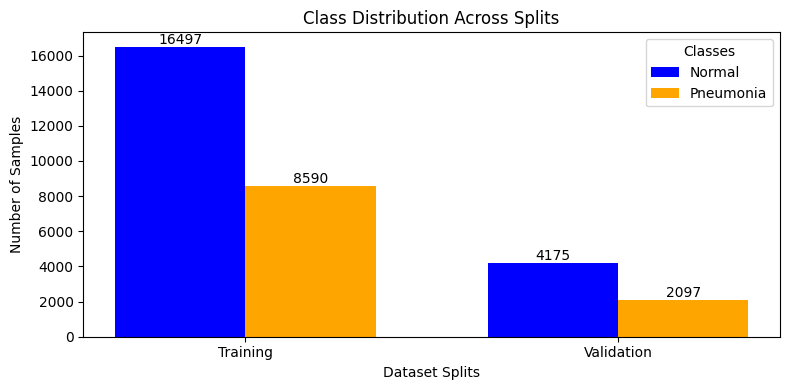

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Dados
splits = ['Training', 'Validation']
classes = ['Normal', 'Pneumonia']
train_counts = [train_data['Target'].value_counts()[0], train_data['Target'].value_counts()[1]]
val_counts = [val_data['Target'].value_counts()[0], val_data['Target'].value_counts()[1]]

# Configurar as posições no eixo X
x = np.arange(len(splits))  # Posições para os splits (Training, Validation)
bar_width = 0.35  # Largura das barras

# Criar o gráfico de barras lado a lado
fig, ax = plt.subplots(figsize=(8, 4))
normal_bars = ax.bar(x - bar_width/2, [train_counts[0], val_counts[0]], bar_width, label='Normal', color='blue')
pneumonia_bars = ax.bar(x + bar_width/2, [train_counts[1], val_counts[1]], bar_width, label='Pneumonia', color='orange')

# Adicionar rótulos numéricos nas barras
for bar in normal_bars:
    ax.annotate(f"{bar.get_height():.0f}",
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center', va='bottom', fontsize=10)

for bar in pneumonia_bars:
    ax.annotate(f"{bar.get_height():.0f}",
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center', va='bottom', fontsize=10)

# Personalizar os eixos
ax.set_xlabel('Dataset Splits')
ax.set_ylabel('Number of Samples')
ax.set_title('Class Distribution Across Splits')
ax.set_xticks(x)
ax.set_xticklabels(splits)
ax.legend(title='Classes')

# Melhorar layout
plt.tight_layout()
plt.show()


In [18]:
import numpy as np
import pandas as pd

# Define o tamanho alvo para a classe minoritária (número total de amostras desejadas na classe minoritária após oversampling)
target_size_minority = 14000

# Separa os dados de treino em duas classes:
# train_class_0 -> Contém amostras da classe majoritária (Normal, Target = 0)
# train_class_1 -> Contém amostras da classe minoritária (Pneumonia, Target = 1)
train_class_0 = train_data[train_data['Target'] == 0]  # Classe majoritária
train_class_1 = train_data[train_data['Target'] == 1]  # Classe minoritária

# Calcula o número de replicações necessárias para cada imagem da classe minoritária:
# n_repeats -> Número inteiro de vezes que cada imagem será replicada para atingir o tamanho alvo.
# n_remainder -> Número restante de amostras necessárias após as replicações uniformes.
n_repeats = target_size_minority // len(train_class_1)  # Divisão inteira
n_remainder = target_size_minority % len(train_class_1)  # Restante das amostras

# Realiza replicações uniformes:
# Replica uniformemente cada imagem da classe minoritária n_repeats vezes.
oversampled_class_1 = pd.concat([train_class_1] * n_repeats, ignore_index=True)

# Adiciona o número restante de amostras (n_remainder) de forma aleatória e sem reposição.
oversampled_class_1 = pd.concat([
    oversampled_class_1,
    train_class_1.sample(n=n_remainder, replace=False, random_state=42)
], ignore_index=True)

# Combina as duas classes (majoritária e minoritária balanceada):
# Combina train_class_0 (classe majoritária) com oversampled_class_1 (classe minoritária balanceada).
# Embaralha os dados para garantir uma ordem aleatória.
balanced_train_data = pd.concat([train_class_0, oversampled_class_1])
balanced_train_data = balanced_train_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Exibe a nova distribuição das classes no conjunto de treino balanceado.
print("Distribuição do conjunto de treino após oversampling uniforme:")
print(balanced_train_data['Target'].value_counts())

Distribuição do conjunto de treino após oversampling uniforme:
Target
0    16497
1    14000
Name: count, dtype: int64


In [19]:
# Verificar o tamanho final das classes
print("Distribuição do conjunto de treino após oversampling uniforme:")
print(balanced_train_data['Target'].value_counts())

# Verificar duplicatas na classe minoritária
minority_data = balanced_train_data[balanced_train_data['Target'] == 1]

# Contar quantas vezes cada 'patientId' aparece
patient_id_counts = minority_data['patientId'].value_counts()

# Exibir os primeiros exemplos
print("\nOcorrências por patientId na classe minoritária (exemplo):")
print(patient_id_counts.head())

# Estatísticas das duplicatas
print("\nEstatísticas das duplicatas na classe minoritária:")
print(f"Máximo de duplicatas por patientId: {patient_id_counts.max()}")
print(f"Mínimo de duplicatas por patientId: {patient_id_counts.min()}")
print(f"Total de IDs duplicados: {sum(patient_id_counts > 1)}")

# Verificar se o número total de duplicatas faz sentido
print(f"\nTotal de amostras na classe minoritária: {len(minority_data)}")
print(f"Número único de patientIds na classe minoritária: {len(patient_id_counts)}")


Distribuição do conjunto de treino após oversampling uniforme:
Target
0    16497
1    14000
Name: count, dtype: int64

Ocorrências por patientId na classe minoritária (exemplo):
patientId
359ce100-a41f-40e2-ba95-c91b83725a35    2
abc5356a-b8b2-4a0b-9dab-14c54efb4f29    2
patient26616_study1_view1_frontal       2
9bb53dc0-28ed-47ed-bff3-9e6cc3c03d62    2
patient37912_study2_view1_frontal       2
Name: count, dtype: int64

Estatísticas das duplicatas na classe minoritária:
Máximo de duplicatas por patientId: 2
Mínimo de duplicatas por patientId: 1
Total de IDs duplicados: 5410

Total de amostras na classe minoritária: 14000
Número único de patientIds na classe minoritária: 8590


In [20]:
# Verificar duplicatas no conjunto balanceado
num_duplicates = balanced_train_data.duplicated(subset=['patientId']).sum()
print(f"Número de duplicatas no dataset balanceado: {num_duplicates}")

Número de duplicatas no dataset balanceado: 5410


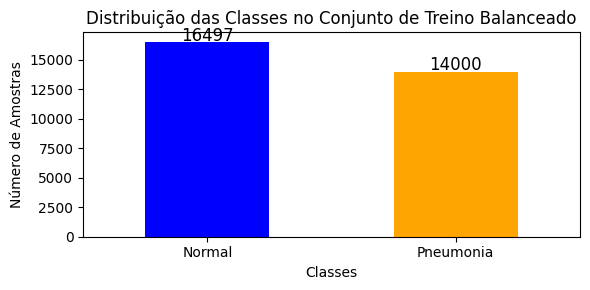

In [21]:
import matplotlib.pyplot as plt

# Criar um gráfico de barras para mostrar a distribuição das classes no conjunto balanceado
balanced_train_data['Target'].value_counts().plot(kind='bar', figsize=(6, 3), title='Distribuição das Classes no Conjunto de Treino Balanceado', color=['blue', 'orange'])

# Adicionar rótulos aos eixos
plt.xlabel('Classes')
plt.ylabel('Número de Amostras')
plt.xticks([0, 1], ['Normal', 'Pneumonia'], rotation=0)

# Adicionar valores numéricos acima das barras
for i, count in enumerate(balanced_train_data['Target'].value_counts()):
    plt.text(i, count + 100, str(count), ha='center', fontsize=12)

plt.tight_layout()
plt.show()



Frequência de duplicatas na classe minoritária (Pneumonia):
count
2    5410
1    3180
Name: count, dtype: int64


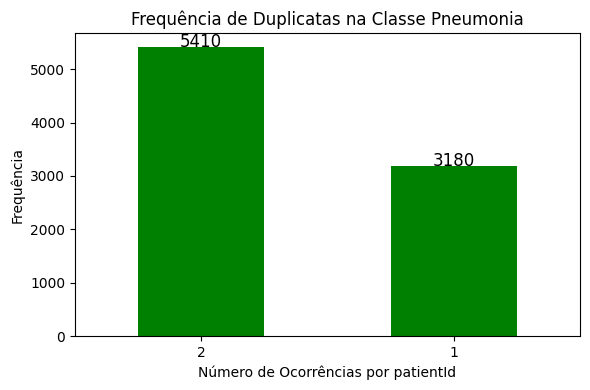

In [22]:
# Contar a frequência de duplicatas na classe minoritária
dup_counts = patient_id_counts.value_counts()

# Exibir as contagens
print("\nFrequência de duplicatas na classe minoritária (Pneumonia):")
print(dup_counts)

# Plotar um gráfico de barras para mostrar a frequência de duplicatas
dup_counts.plot(kind='bar', figsize=(6, 4), title='Frequência de Duplicatas na Classe Pneumonia', color='green')

# Adicionar rótulos aos eixos
plt.xlabel('Número de Ocorrências por patientId')
plt.ylabel('Frequência')
plt.xticks(rotation=0)

# Adicionar valores numéricos acima das barras
for i, count in enumerate(dup_counts):
    plt.text(i, count + 10, str(count), ha='center', fontsize=12)

plt.tight_layout()
plt.show()


In [23]:
import os

# Diretórios das classes
normal_dir = '/notebooks/RSNA_Pneumonia/Normal'
pneumonia_dir = '/notebooks/RSNA_Pneumonia/Pneumonia'

# Função para verificar se os arquivos das classes estão nas pastas corretas
def check_images_in_class_directory(data, class_dir, set_name, class_label):
    missing_files = []  # Lista para armazenar arquivos ausentes
    # Filtrar os dados da classe atual
    image_paths = data[data['Target'] == class_label]['patientId'].tolist()

    # Verificar se os arquivos existem
    for img in image_paths:
        img_filename = f"{img}.png"  # Adiciona a extensão .png ao nome do arquivo
        img_path = os.path.join(class_dir, img_filename)
        if not os.path.isfile(img_path):
            missing_files.append(img_filename)

    # Exibir resultados
    if missing_files:
        print(f"{len(missing_files)} arquivos ausentes na classe '{class_label}' do conjunto {set_name}.")
        print(f"Exemplos de arquivos ausentes: {missing_files[:5]}")
    else:
        print(f"Todos os arquivos da classe '{class_label}' no conjunto {set_name} estão presentes.")

# Verificar as imagens para o conjunto de treino
print("Verificando o conjunto de treino:")
check_images_in_class_directory(train_data, normal_dir, 'Training', 0)  # Classe Normal (Target = 0)
check_images_in_class_directory(train_data, pneumonia_dir, 'Training', 1)  # Classe Pneumonia (Target = 1)

# Verificar as imagens para o conjunto de validação
print("\nVerificando o conjunto de validação:")
check_images_in_class_directory(val_data, normal_dir, 'Validation', 0)  # Classe Normal (Target = 0)
check_images_in_class_directory(val_data, pneumonia_dir, 'Validation', 1)  # Classe Pneumonia (Target = 1)


Verificando o conjunto de treino:
Todos os arquivos da classe '0' no conjunto Training estão presentes.
Todos os arquivos da classe '1' no conjunto Training estão presentes.

Verificando o conjunto de validação:
Todos os arquivos da classe '0' no conjunto Validation estão presentes.
Todos os arquivos da classe '1' no conjunto Validation estão presentes.


In [24]:
import numpy as np
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# --- Função para processar os rótulos ---
def process_labels(data, name, one_hot=True):
    """
    Processa rótulos para treino ou validação e verifica alinhamento.

    Parameters:
        data (DataFrame): DataFrame contendo a coluna 'Target'.
        name (str): Nome do conjunto ('Treino' ou 'Validação').
        one_hot (bool): Se True, transforma para One-Hot Encoding.

    Returns:
        tf.Tensor: Rótulos processados (One-Hot ou binário).
    """
    if one_hot:
        # Converter para One-Hot Encoding
        y_data = to_categorical(data['Target'], num_classes=2)
    else:
        # Usar formato binário (0 ou 1)
        y_data = data['Target'].values

    # Converter para tensores compatíveis com TensorFlow
    y_data = tf.cast(y_data, tf.float32)
    
    # Verificar alinhamento
    assert len(data) == len(y_data), f"Misalignment still exists between {name} data and labels"
    
    # Exibir informações
    print(f"Forma de y_{name.lower()}: {y_data.shape}, Valores únicos: {np.unique(data['Target'].values)}")
    print(f"Labels estão alinhados com os dados de {name.lower()}.\n")
    
    return y_data


one_hot_encoding = True  # Ajuste para True se desejar One-Hot Encoding(softmax), False se desejar binario(sigmoid)

# Processar rótulos para treino e validação
y_train = process_labels(balanced_train_data, name="Treino", one_hot=one_hot_encoding)
y_val = process_labels(val_data, name="Validação", one_hot=one_hot_encoding)


Forma de y_treino: (30497, 2), Valores únicos: [0 1]
Labels estão alinhados com os dados de treino.

Forma de y_validação: (6272, 2), Valores únicos: [0 1]
Labels estão alinhados com os dados de validação.



In [25]:
# Verifica o formato dos rotulos gerados
print("Formato de y_train (binário(30497,)/softmax(30497,2)):", y_train.shape)  # Deve ser (n_samples,)
print("Exemplo de valores:", y_train[:5])  # Algo como [0, 1, 1, 0, 0]

Formato de y_train (binário(30497,)/softmax(30497,2)): (30497, 2)
Exemplo de valores: tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(5, 2), dtype=float32)


In [26]:
print(f"Tamanho do DataFrame balanced_train_data: {len(balanced_train_data)}")
print(f"Tamanho do array de rótulos y_train: {len(y_train)}")

Tamanho do DataFrame balanced_train_data: 30497
Tamanho do array de rótulos y_train: 30497


Exibindo amostras da classe Normal:


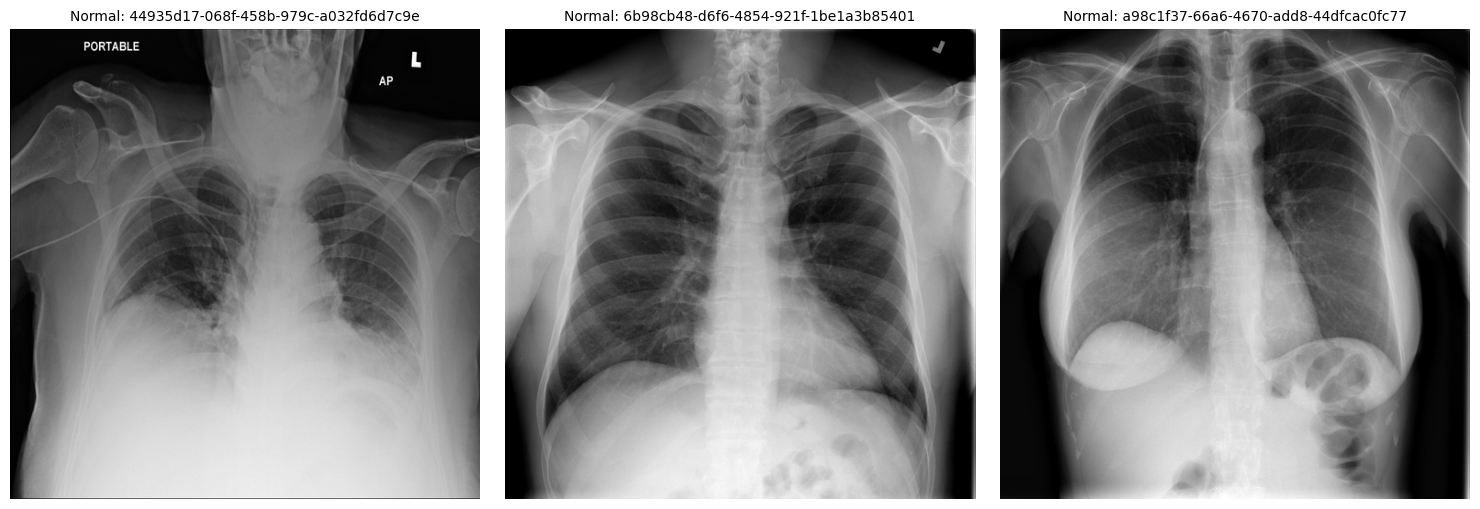

Exibindo amostras da classe Pneumonia:


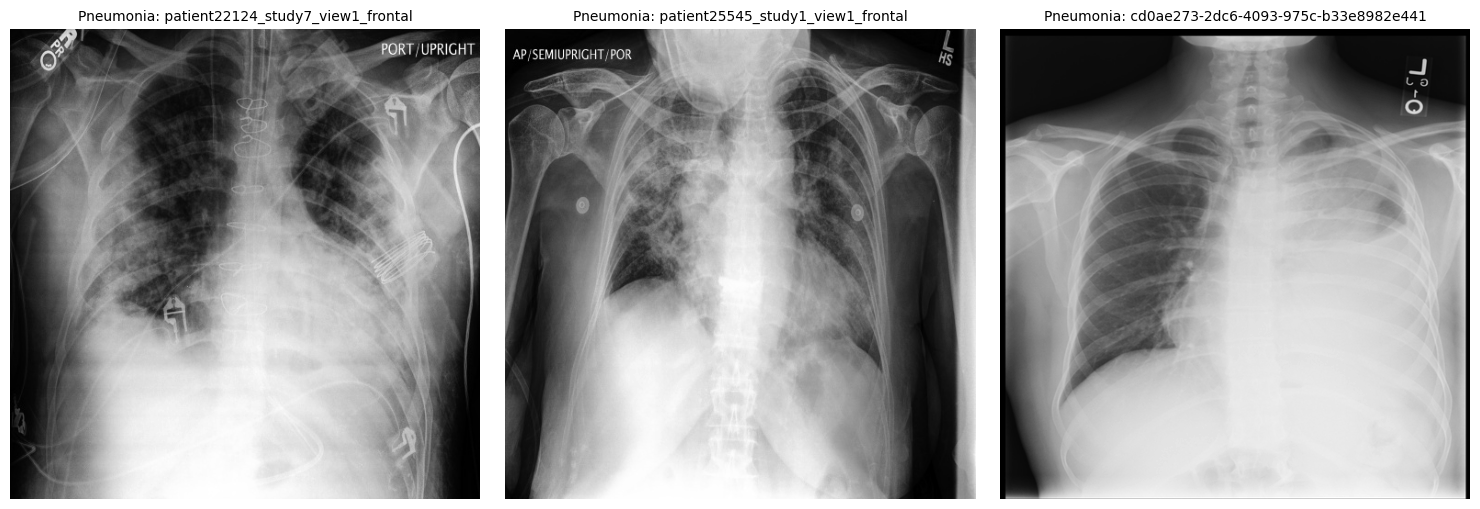

In [27]:
import random
import matplotlib.pyplot as plt
import cv2
import os

# Diretórios das imagens
normal_dir = "/notebooks/RSNA_Pneumonia/Normal"
pneumonia_dir = "/notebooks/RSNA_Pneumonia/Pneumonia"

# Função para mostrar imagens lado a lado
def show_images_with_labels(image_paths, class_name):
    plt.figure(figsize=(15, 5))  # Tamanho da figura
    for i, image_path in enumerate(image_paths):
        if os.path.isfile(image_path):  # Verificar se o arquivo existe
            # Ler a imagem em escala de cinza
            img = cv2.imread(image_path, 0)
            img_id = os.path.splitext(os.path.basename(image_path))[0]  # Extrair ID da imagem
            plt.subplot(1, len(image_paths), i + 1)  # Configurar o subplot
            plt.imshow(img, cmap='gray')  # Exibir a imagem
            plt.title(f"{class_name}: {img_id}", fontsize=10)  # Mostrar classe e ID
            plt.axis('off')  # Remover os eixos
        else:
            print(f"Imagem {image_path} não encontrada.")  # Arquivo ausente
    plt.tight_layout()  # Ajustar os espaçamentos entre os subplots
    plt.show()

# Selecionar amostras aleatórias
num_samples = 3  # Número de imagens para exibir
random_normal = random.sample(os.listdir(normal_dir), min(num_samples, len(os.listdir(normal_dir))))
random_pneumonia = random.sample(os.listdir(pneumonia_dir), min(num_samples, len(os.listdir(pneumonia_dir))))

# Adicionar o caminho completo às imagens selecionadas
normal_images = [os.path.join(normal_dir, img) for img in random_normal]
pneumonia_images = [os.path.join(pneumonia_dir, img) for img in random_pneumonia]

# Exibir imagens da classe Normal
print("Exibindo amostras da classe Normal:")
show_images_with_labels(normal_images, "Normal")

# Exibir imagens da classe Pneumonia
print("Exibindo amostras da classe Pneumonia:")
show_images_with_labels(pneumonia_images, "Pneumonia")


In [28]:
# Função para Construir os Caminhos de Imagem

def create_image_paths(dataframe, normal_dir, pneumonia_dir):
    """
    Retorna uma lista de caminhos de imagens e os rótulos correspondentes.
    """
    image_paths = []
    for _, row in dataframe.iterrows():
        dir_path = normal_dir if row['Target'] == 0 else pneumonia_dir
        img_path = os.path.join(dir_path, f"{row['patientId']}.png")
        image_paths.append(img_path)
    return image_paths

# Gerar caminhos para o dataset balanceado (train) e validação (val)
train_image_paths = create_image_paths(balanced_train_data, normal_dir, pneumonia_dir)
val_image_paths   = create_image_paths(val_data, normal_dir, pneumonia_dir)

print(f"Número de imagens no treino: {len(train_image_paths)}")
print(f"Número de imagens na validação: {len(val_image_paths)}")


Número de imagens no treino: 30497
Número de imagens na validação: 6272


In [29]:
# Função de Pré-Processamento (EfficientNet) ter em atencao de comentar a normalizacao nao desejada
# Neste caso usamos [-1..1] que é a mais indicada para o EfficientNet
#import tensorflow as tf
#from tensorflow.keras.applications.inception_v3 import preprocess_input # (299, 299), [-1, 1]
#from tensorflow.keras.applications.efficientnet import preprocess_input # (224,240,260,300,380,456), [0, 255]
#from tensorflow.keras.applications.efficientnet_v2 import preprocess_input # EfficientNetV2S/M/L (300,384,480)
#from tensorflow.keras.applications.resnet import preprocess_input # (224)
from tensorflow.keras.applications.resnet_v2 import preprocess_input # 224x224, mas pode ser aumentado para 384x384 ou 512x512.
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input (224), [-1, 1]
#from tensorflow.keras.applications.xception import preprocess_input # (299,512), [-1, 1]
#from tensorflow.keras.applications.densenet import preprocess_input

IMAGE_SIZE = (384, 384)
BATCH_SIZE = 64

def load_and_preprocess_image(img_path, label):
    # Ler e decodificar
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=1)  # grayscale

    # Redimensionar
    img = tf.image.resize(img, IMAGE_SIZE)

    # Converter para RGB
    img = tf.image.grayscale_to_rgb(img)

    # Aplicar preprocess_input para normalizar em função do import preprocess_input escolhido 
    img = preprocess_input(img)

    return img, label

In [30]:
#import tensorflow as tf
def tfa_rotate_alternative(image, angle_rad):
    """
    Rotação arbitrária sem usar TensorFlow Addons (compatível com tensores simbólicos).
    """
    # Calcular seno e cosseno do ângulo
    angle_sin = tf.sin(angle_rad)
    angle_cos = tf.cos(angle_rad)

    # Construir a matriz de transformação com 9 elementos
    rotation_matrix = tf.convert_to_tensor([
        angle_cos, -angle_sin, 0.0,
        angle_sin, angle_cos, 0.0,
        0.0, 0.0, 1.0
    ])
    
    # Transformação precisa ter tamanho [1, 8] (remover o último elemento)
    transforms = tf.reshape(rotation_matrix[:8], [1, 8])

    # Dimensões da imagem
    image_shape = tf.shape(image)
    height, width = image_shape[0], image_shape[1]

    # Aplicar a transformação com preenchimento
    rotated_image = tf.raw_ops.ImageProjectiveTransformV3(
        images=tf.expand_dims(image, 0),  # Adiciona dimensão batch
        transforms=transforms,
        output_shape=[height, width],
        interpolation="BILINEAR",
        fill_mode="CONSTANT", 
        fill_value=0.0  # Preto, consistente com o fundo de raios-X
    )
    return tf.squeeze(rotated_image, axis=0)  # Remove dimensão batch

In [31]:
def random_pad1(image, max_pad=20, target_size=IMAGE_SIZE):
    """
    Aplica padding aleatório à imagem para deslocar seu conteúdo.
    
    Args:
        image (tensor): Imagem de entrada.
        max_pad (int): Número máximo de pixels que podem ser adicionados em cada borda.
        target_size (tuple): Tamanho final da imagem após o padding.
        
    Returns:
        tensor: Imagem com padding aleatório garantidamente no tamanho correto.
    """
    pad_top = tf.random.uniform([], minval=0, maxval=max_pad, dtype=tf.int32)
    pad_bottom = tf.random.uniform([], minval=0, maxval=max_pad, dtype=tf.int32)
    pad_left = tf.random.uniform([], minval=0, maxval=max_pad, dtype=tf.int32)
    pad_right = tf.random.uniform([], minval=0, maxval=max_pad, dtype=tf.int32)

    # Aplica o padding aleatório
    image = tf.pad(image, [[pad_top, pad_bottom], [pad_left, pad_right], [0, 0]], mode="CONSTANT", constant_values=0)

    # Garante que a imagem volte ao tamanho esperado
    image = tf.image.resize(image, target_size)

    return image


In [32]:
def random_pad(image, max_pad=25, target_size=IMAGE_SIZE):
    pad = tf.random.uniform([], minval=0, maxval=max_pad, dtype=tf.int32)

    # Adiciona padding simétrico nos quatro lados
    image = tf.pad(image, [[pad, pad], [pad, pad], [0, 0]], mode="CONSTANT", constant_values=0)

    # Redimensiona garantindo que o fundo fique preto puro
    image = tf.image.resize(image, target_size, method="nearest")

    return image


In [33]:
def random_augment(image, label):
    
    #image = tf.image.flip_left_right(image) # Nunca utilizar com imagens medicas. somente para verificação da função! 
    
    angle_rad = tf.random.uniform([], minval=-25, maxval=25, dtype=tf.float32) * (3.14159265359 / 180)
    image = tfa_rotate_alternative(image, angle_rad)
    
    # Ajustar brilho
    image = tf.image.random_brightness(image, max_delta=0.25)
    
    # Ajustar contraste
    image = tf.image.random_contrast(image, lower=0.75, upper=1.25)
    
    # Zoom aleatório
    zoom_scale = tf.random.uniform([], minval=0.95, maxval=1.05)
    height, width = tf.shape(image)[0], tf.shape(image)[1]
    new_height = tf.cast(zoom_scale * tf.cast(height, tf.float32), tf.int32)
    new_width = tf.cast(zoom_scale * tf.cast(width, tf.float32), tf.int32)
    image = tf.image.resize(image, [new_height, new_width])
    image = tf.image.resize_with_crop_or_pad(image, height, width)
    
    # Adicionando padding aleatório
    image = random_pad(image, max_pad=15)
    
    return image, label

In [34]:
# Criar o tf.data.Dataset - Importante: Agora train_labels e val_labels já são arrays one-hot (N, 2).

def create_tf_dataset(image_paths, labels, batch_size, augment=False, shuffle=False):
    """
    Cria um dataset usando tf.data, com opções de augmentação.
    """
    
    # Converter para tf.constant (otimização para evitar overhead)
    #image_paths = tf.constant(image_paths)
    #labels = tf.constant(labels)
    
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    ds = ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(image_paths), 5000))

    if augment:
        ds = ds.map(random_augment, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = create_tf_dataset(
    train_image_paths, y_train, batch_size=BATCH_SIZE, augment=True, shuffle=True
)
val_dataset = create_tf_dataset(
    val_image_paths, y_val, batch_size=BATCH_SIZE, augment=False, shuffle=False
)

print(f"Datasets criados com sucesso! Tamanho do batch: {BATCH_SIZE}")

Datasets criados com sucesso! Tamanho do batch: 64


# Verificação das imagens do train_dataset - augment=True/False
# Crie um dataset sem aumento para verificar o pré-processamento básico
debug_dataset = create_tf_dataset(train_image_paths, y_train, BATCH_SIZE, augment=False, shuffle=False)
for img, lbl in debug_dataset.take(3):
    # Desnormalização (ajuste conforme o pré-processamento usado)
    #img_display = (img[0].numpy() * 255).astype('uint8')  # Para normalização [0, 1]
    #img_display = ((img[0].numpy() + 1) * 127.5).astype('uint8')  # Para normalização [-1, 1]
    plt.imshow(img[0].numpy().astype('uint8')) # [0, 255]
    plt.title(f"Label: {lbl[0].numpy()}")
    plt.show()
    
# Visualizar 3 imagens do dataset de treino (com aumento)
for img, lbl in train_dataset.take(3):
    plt.imshow(img[0].numpy().astype('uint8'))  # Exibição sem desnormalização
    plt.title(f"Label: {lbl[0].numpy()}")
    plt.show()

# Visualizar 3 imagens do dataset de validação (sem aumento)
for img, lbl in val_dataset.take(3):
    plt.imshow(img[0].numpy().astype('uint8'))
    plt.title(f"Label: {lbl[0].numpy()}")
    plt.show()

In [35]:
# Verificar o formato dos batches
for x_batch, y_batch in train_dataset.take(1):
    print(f"Shape das imagens: {x_batch.shape}, Shape dos rótulos: {y_batch.shape}")

Shape das imagens: (64, 384, 384, 3), Shape dos rótulos: (64, 2)


In [36]:
for x_batch, _ in val_dataset.take(1):
    print(f"Image batch min: {tf.reduce_min(x_batch).numpy()}, max: {tf.reduce_max(x_batch).numpy()}")

Image batch min: -1.0, max: 1.0


In [37]:
# =============================================================================
# Função para inspecionar valores min e max das imagens
# =============================================================================
def inspect_image_range(dataset, num_images=5):
    """
    Inspeciona min e max das imagens de um batch do dataset.
    """
    for images, labels in dataset.take(1):
        print("Valores mínimos e máximos de algumas imagens:")
        for i in range(min(num_images, images.shape[0])):
            min_val = tf.reduce_min(images[i]).numpy()
            max_val = tf.reduce_max(images[i]).numpy()
            print(f"Imagem {i + 1}: min={min_val}, max={max_val}")
        break

# Exemplo de inspeção no conjunto de treino
inspect_image_range(train_dataset)

Valores mínimos e máximos de algumas imagens:
Imagem 1: min=-0.8498068451881409, max=0.7224072813987732
Imagem 2: min=-1.1953999996185303, max=0.7576219439506531
Imagem 3: min=-0.7455359697341919, max=0.724982738494873
Imagem 4: min=-1.0975921154022217, max=0.0
Imagem 5: min=-0.946178138256073, max=0.2900550365447998


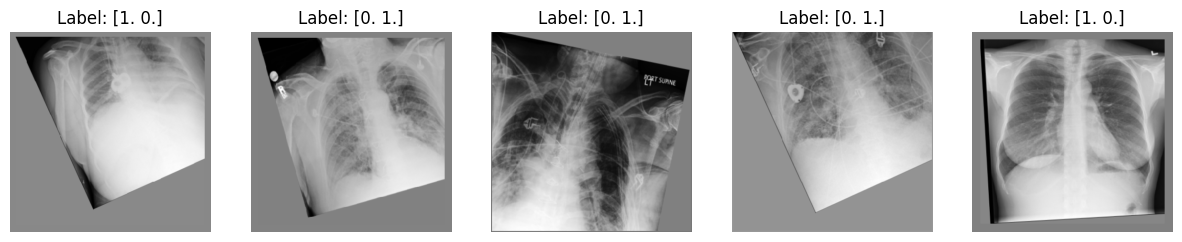

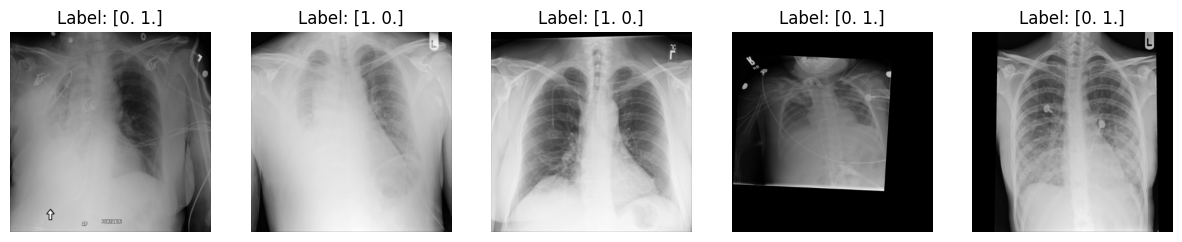

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# Função de visualização (para debug)
# =============================================================================
def visualize_dataset(dataset, num_images=5):
    """
    Exibe algumas imagens do dataset.
    (Para debug: converte de [-1..1] ou outro range para [0..1] antes de imshow)
    """
    for images, labels in dataset.take(1):
        plt.figure(figsize=(15, 15))
        for i in range(min(num_images, images.shape[0])):
            plt.subplot(1, num_images, i + 1)
            img_disp = images[i].numpy()
            
            # Converte qualquer range para [0..1] para exibição
            min_val, max_val = img_disp.min(), img_disp.max()
            img_disp = (img_disp - min_val) / (max_val - min_val + 1e-7)

            plt.imshow(img_disp)
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis('off')
        plt.show()
        break

# Visualizar treino e validação
visualize_dataset(train_dataset)
visualize_dataset(val_dataset)

In [39]:
# Criar um mapeamento de nomes de classes para seus índices correspondentes
# Isso é útil para referência consistente durante o treinamento e avaliação.

# Nomes das classes no problema atual
target_classes = ['Normal', 'Pneumonia']

# Mapear os nomes das classes para seus respectivos índices
class_indices = {class_name: idx for idx, class_name in enumerate(target_classes)}

# Exibir o mapeamento
print("Mapeamento de índices das classes:", class_indices)

Mapeamento de índices das classes: {'Normal': 0, 'Pneumonia': 1}


In [40]:
import os

# Lista de arquivos completos em cada diretório
normal_files = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir) if f.endswith('.png')]
pneumonia_files = [os.path.join(pneumonia_dir, f) for f in os.listdir(pneumonia_dir) if f.endswith('.png')]

# Função para verificar imagens e exibir resultados
def check_images(image_paths, dataset_name):
    missing_in_normal = [img for img in image_paths if img in normal_files]
    missing_in_pneumonia = [img for img in image_paths if img in pneumonia_files]
    missing_images = [img for img in image_paths if img not in normal_files and img not in pneumonia_files]

    # Verificar se os arquivos existem no sistema
    nonexistent_images = [img for img in missing_images if not os.path.exists(img)]
    present_images = [img for img in missing_images if os.path.exists(img)]

    print(f"\nResultados para o conjunto {dataset_name}:")
    print(f"Imagens encontradas em Normal: {len(missing_in_normal)}")
    print(f"Imagens encontradas em Pneumonia: {len(missing_in_pneumonia)}")
    print(f"Imagens ausentes: {len(missing_images)}")
    if nonexistent_images:
        print(f"{len(nonexistent_images)} imagens não existem fisicamente no sistema.")
        print(f"Exemplos de imagens inexistentes: {nonexistent_images[:5]}")
    if present_images:
        print(f"{len(present_images)} imagens estão fora das pastas esperadas (Normal ou Pneumonia).")
        print(f"Exemplos de imagens presentes fora das pastas: {present_images[:5]}")

# Verificar imagens para treino
check_images(train_image_paths, "treino")

# Verificar imagens para validação
check_images(val_image_paths, "validação")


Resultados para o conjunto treino:
Imagens encontradas em Normal: 16497
Imagens encontradas em Pneumonia: 14000
Imagens ausentes: 0

Resultados para o conjunto validação:
Imagens encontradas em Normal: 4175
Imagens encontradas em Pneumonia: 2097
Imagens ausentes: 0


In [41]:
import numpy as np
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

# =======================
# 1️⃣ UTILITÁRIOS: Cálculo de Frequências e Pesos
# =======================

def calculate_frequencies(y_train):
    """
    Calcula as frequências das classes, adaptando-se a rótulos binários ou one-hot encoded.
    """
    if len(y_train.shape) == 1:  # Rótulos binários
        positive_counts = np.array([np.sum(y_train), len(y_train) - np.sum(y_train)])
    else:  # One-hot encoded
        positive_counts = np.sum(y_train, axis=0)
    
    total_counts = len(y_train)
    frequencies = positive_counts / total_counts
    return positive_counts, total_counts, frequencies


def calculate_alpha_weights(frequencies):
    """
    Calcula os pesos alpha inversamente proporcionais às frequências das classes.
    """
    alpha = 1 / (frequencies + 1e-6)  # Evita divisão por zero
    alpha = alpha / np.sum(alpha)  # Normaliza os pesos
    return alpha


def calculate_class_weights(frequencies, use_original_distribution=True):
    """
    Calcula os pesos das classes com base na distribuição original ou na distribuição após oversampling.
    
    Args:
        frequencies (numpy array): Frequências das classes.
        use_original_distribution (bool): Se True, usa a distribuição original dos dados. 
                                          Se False, usa a distribuição após oversampling.
    
    Returns:
        dict: Dicionário com os pesos das classes.
    """
    if use_original_distribution:
        # Frequências originais (antes do oversampling)
        original_frequencies = np.array([0.6576, 0.3424])  # Substitua pelos valores reais da sua distribuição original
        class_weights = 1 / (original_frequencies + 1e-6)  # Inversamente proporcional às frequências originais
        class_weights = class_weights / np.mean(class_weights)  # Normaliza para média 1
    else:
        # Frequências após oversampling
        class_weights = 1 / (frequencies + 1e-6)  # Inversamente proporcional às frequências atuais
        class_weights = class_weights / np.mean(class_weights)  # Normaliza para média 1
    
    return dict(enumerate(class_weights))


# =======================
# 2️⃣ FUNÇÕES DE FOCAL LOSS
# =======================

def focal_loss_with_alpha(gamma=2., alpha=None):
    """
    Implementação da Focal Loss com ajuste de pesos alpha.
    """
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())  # Evita log(0)
        bce = K.binary_crossentropy(y_true, y_pred)  # Calcula Binary Crossentropy
        pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)  # Probabilidade verdadeira
        focal_factor = K.pow(1. - pt, gamma)  # Reduz impacto de amostras fáceis
        
        if alpha is not None:
            alpha_tensor = K.constant(alpha, dtype=K.floatx())  # Converte alpha para tensor
            alpha_factor = y_true * alpha_tensor + (1 - y_true) * (1 - alpha_tensor)  # Ajuste por amostra
            fl = alpha_factor * focal_factor * bce  # Aplica Focal Loss com pesos alpha
        else:
            fl = focal_factor * bce  # Aplica Focal Loss normal
        return K.mean(fl, axis=-1)
    
    return focal_loss_fixed


def focal_loss_with_class_weights(gamma=2., class_weights=None):
    """
    Implementação da Focal Loss com pesos por classe.
    """
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())  # Evita log(0)
        cce = K.categorical_crossentropy(y_true, y_pred)  # Usa Categorical Crossentropy
        pt = K.sum(y_true * y_pred, axis=-1)  # Probabilidade correta da amostra
        focal_factor = K.pow(1. - pt, gamma)  # Ajuste da loss
        
        if class_weights is not None:
            class_weights_tensor = K.constant(list(class_weights.values()), dtype=K.floatx())  # Converte para tensor
            class_weights_tensor = K.reshape(class_weights_tensor, (1, -1))  # Ajusta a dimensão
            class_weights_factor = K.sum(y_true * class_weights_tensor, axis=-1)  # Pesa a loss por classe
            fl = focal_factor * cce * class_weights_factor
        else:
            fl = focal_factor * cce
        
        return K.mean(fl)
    
    return focal_loss_fixed

# =======================
# 3️⃣ CÁLCULO DE PESOS E CONFIGURAÇÃO DA LOSS
# =======================

# Suponha que y_train seja fornecido pelo dataset (após oversampling)
# Certifique-se de que y_train esteja no formato correto (one-hot encoded)
#y_train = np.array([...])  # Insira aqui seus rótulos (one-hot encoded)

# Calcular frequências
positive_counts, total_counts, frequencies = calculate_frequencies(y_train)

# Calcular alpha (baseado nas frequências atuais)
alpha = calculate_alpha_weights(frequencies)
print("Pesos alpha:", alpha)

# Opção 1: Usar distribuição original (antes do oversampling)
class_weights_original = calculate_class_weights(frequencies, use_original_distribution=True)
print("Pesos com base na distribuição original:", class_weights_original)

# Opção 2: Usar distribuição balanceada (após oversampling)
class_weights_balanced = calculate_class_weights(frequencies, use_original_distribution=False)
print("Pesos com base na distribuição balanceada:", class_weights_balanced)

# Escolher qual usar
use_original = False  # Altere para False se preferir usar a distribuição balanceada
if use_original:
    class_weights = class_weights_original
else:
    class_weights = class_weights_balanced

# Exibir valores calculados
print("Frequências das classes:", frequencies)
print("Pesos das classes selecionados:", class_weights)

# Escolher qual Focal Loss usar
# Opção 1: Usar focal_loss_with_class_weights
loss_function = focal_loss_with_class_weights(gamma=2., class_weights=class_weights)

# Opção 2: Usar focal_loss_with_alpha (se preferir alpha)
# loss_function = focal_loss_with_alpha(gamma=2., alpha=alpha)

Pesos alpha: [0.45906165 0.5409384 ]
Pesos com base na distribuição original: {0: 0.6848006303987392, 1: 1.315199369601261}
Pesos com base na distribuição balanceada: {0: 0.9181233, 1: 1.0818768}
Frequências das classes: [0.54093844 0.45906153]
Pesos das classes selecionados: {0: 0.9181233, 1: 1.0818768}


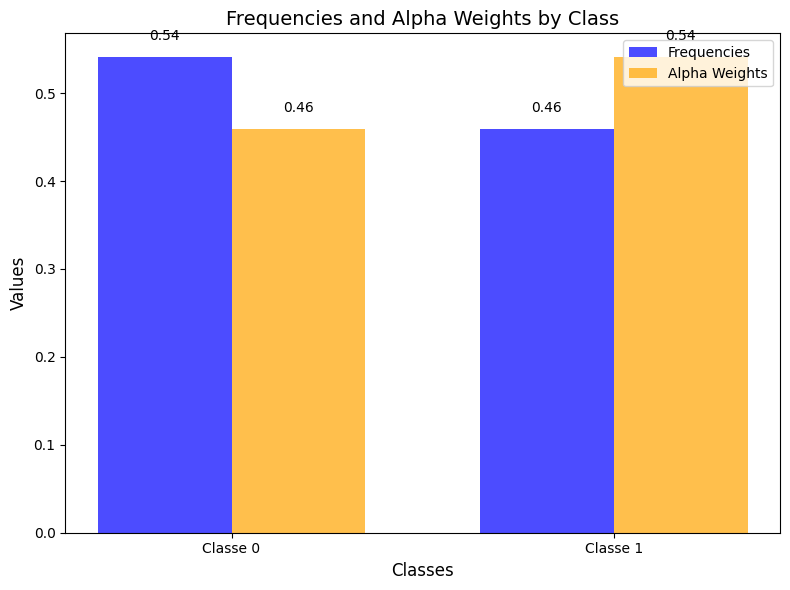

In [42]:
import matplotlib.pyplot as plt

# Criar o gráfico
fig, ax = plt.subplots(figsize=(8, 6))

# Definir rótulos das classes (modifique conforme seu dataset)
classes = [f"Classe {i}" for i in range(len(frequencies))]  # Exemplo de rótulos: "Classe 0", "Classe 1"

# Definir largura das barras
x = np.arange(len(classes))
width = 0.35

# Adicionar barras de Frequências e Pesos Alpha
bars1 = ax.bar(x - width / 2, frequencies, width, label="Frequencies", color="blue", alpha=0.7)
bars2 = ax.bar(x + width / 2, alpha, width, label="Alpha Weights", color="orange", alpha=0.7)

# Adicionar rótulos numéricos nas barras
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f"{yval:.2f}", ha="center", fontsize=10)

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f"{yval:.2f}", ha="center", fontsize=10)

# Ajustar rótulos e título
ax.set_xlabel("Classes", fontsize=12)
ax.set_ylabel("Values", fontsize=12)
ax.set_title("Frequencies and Alpha Weights by Class", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend(loc="upper right", fontsize=10)

# Exibir o gráfico
plt.tight_layout()
plt.show()

In [43]:
# --- Step 46: Configure Focal Loss with Adjusted Parameters ---

# Configura a Focal Loss com parâmetros ajustados para lidar com o desequilíbrio de classes.
USE_CLASS_WEIGHTS = False  # 🔹 Mude para False se quiser usar alpha


if USE_CLASS_WEIGHTS:
    # Opção 1: Focal Loss com pesos de classe
    focal_loss_fn = focal_loss_with_class_weights(
        gamma=2,  # Parâmetro de foco para ajustar a importância de exemplos difíceis de classificar
        class_weights=class_weights  # Pesos específicos das classes calculados anteriormente
    )
    print("🔹 Usando Focal Loss com Class Weights")
else:
    # Opção 2: Focal Loss com Alpha
    focal_loss_fn = focal_loss_with_alpha(
        gamma=3,  # Ajuste para dar mais foco a exemplos difíceis
        alpha=alpha  # Pesos alpha calculados para cada classe
    )
    print("🔹 Usando Focal Loss com Alpha")

    
# --- Step: Define Hybrid Loss Function ---
def hybrid_loss(y_true, y_pred):
    """
    Combina Focal Loss e Categorical Crossentropy em uma função de perda híbrida.

    Parâmetros:
        y_true (tensor): Rótulos verdadeiros.
        y_pred (tensor): Probabilidades previstas.

    Retorna:
        loss (tensor): Valor da perda combinada.
    """
    
    # Depuração opcional para verificar formas dos tensores
    # tf.print("Forma de y_true:", K.shape(y_true))
    # tf.print("Forma de y_pred:", K.shape(y_pred))

    # Focal Loss configurada com os parâmetros definidos
    focal = focal_loss_fn(y_true, y_pred)

    # Categorical Crossentropy com suavização de rótulos para adicionar robustez
    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.05)

    # Combina as perdas com pesos ajustados
    return 0.7 * focal + 0.3 * cce

🔹 Usando Focal Loss com Alpha


In [44]:
import tensorflow as tf

# 🔹 Escolha se deseja usar Softmax ou Sigmoid para a saída
USE_SOFTMAX = True  # 🔄 Mude para False se quiser usar Sigmoid

def focal_loss_dynamic(y_true, y_pred, alpha=0.25, gamma=2.0):
    """
    Implementação dinâmica da Focal Loss para classificação binária.
    Funciona com Softmax ou Sigmoid, dependendo do valor de `USE_SOFTMAX`.

    Parâmetros:
        y_true (tensor): Rótulos verdadeiros (one-hot se Softmax, binário se Sigmoid).
        y_pred (tensor): Probabilidades previstas após Softmax ou Sigmoid.
        alpha (float): Peso para balanceamento de classes.
        gamma (float): Parâmetro de foco para aumentar a importância de exemplos difíceis.

    Retorna:
        loss (tensor): Valor da Focal Loss calculada.
    """

    # Converte y_true para float32
    y_true = tf.cast(y_true, tf.float32)

    # Se for Softmax, já esperamos que y_pred seja um vetor de probabilidades
    if not USE_SOFTMAX:
        # 🔹 Aplicamos Sigmoid e ajustamos para binário
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        ce_loss = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)  # Probabilidade correta
    else:
        # 🔹 Aplicamos Softmax e usamos Categorical Crossentropy
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        ce_loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        pt = tf.reduce_sum(y_true * y_pred, axis=-1)  # Probabilidade correta da classe certa

    # 🔹 Fator modulador (para dar mais peso a exemplos difíceis)
    modulating_factor = tf.pow(1 - pt, gamma)

    # 🔹 Ajuste com alpha para balancear classes (diferente de class_weights)
    alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha) if not USE_SOFTMAX else tf.reduce_sum(y_true * alpha, axis=-1)

    # 🔹 Cálculo final da Focal Loss
    loss = alpha_factor * modulating_factor * ce_loss

    return tf.reduce_mean(loss)

# ✅ Teste rápido com exemplo fictício

if USE_SOFTMAX:
    # 🔹 Para Softmax, rótulos devem estar em one-hot encoding
    y_true_test = tf.constant([[1, 0], [0, 1], [1, 0]], dtype=tf.float32)  # Exemplo binário com one-hot encoding
    y_pred_test = tf.constant([[0.9, 0.1], [0.3, 0.7], [0.8, 0.2]], dtype=tf.float32)  # Probabilidades Softmax
    print("🔹 Usando Softmax + Categorical Crossentropy")
else:
    # 🔹 Para Sigmoid, rótulos devem ser binários (0 ou 1)
    y_true_test = tf.constant([1, 0, 1], dtype=tf.float32)  # Rótulos binários
    y_pred_test = tf.constant([0.9, 0.3, 0.8], dtype=tf.float32)  # Probabilidades Sigmoid
    print("🔹 Usando Sigmoid + Binary Crossentropy")

loss_value = focal_loss_dynamic(y_true_test, y_pred_test)
print(f"🔹 Valor da Focal Loss: {loss_value.numpy():.4f}")

🔹 Usando Softmax + Categorical Crossentropy
🔹 Valor da Focal Loss: 0.0035


In [45]:
# Importações necessárias
from tensorflow.keras.applications import InceptionV3, Xception, DenseNet201, ResNet50, ResNet101V2, EfficientNetB5,EfficientNetB6, MobileNetV2, EfficientNetV2L
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (LeakyReLU, PReLU, Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout, 
BatchNormalization, Conv2D, SeparableConv2D, Multiply)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import roc_curve  # Para cálculo da curva ROC
#from tensorflow.keras.applications import EfficientNetV2M


target_pathologies = ['Normal', 'Pneumonia']

# Função de Pooling com Atenção
def attention_pooling(inputs):
    """
    Aplica uma camada de atenção para ponderar as características extraídas.
    
    Args:
        inputs (tensor): Saída do modelo base (por exemplo, feature maps).
    
    Returns:
        tensor: Saída após aplicação da atenção.
    """
    # Aplicar uma convolução para gerar um mapa de atenção
    attention = Conv2D(1, (1,1), activation="sigmoid")(inputs)
    # Multiplicar as características pelo mapa de atenção
    weighted_inputs = Multiply()([inputs, attention])
    # Reduzir a dimensionalidade com soma
    return tf.reduce_sum(weighted_inputs, axis=[1, 2])


# Configuring MirroredStrategy for multi-GPU training (if applicable)
strategy = tf.distribute.MirroredStrategy()

# Define and compile the model within the strategy scope
with strategy.scope():
    # InceptionV3 -> (299, 299):EfficientNetB6 -> (456, 456):ResNet50 -> (512, 512):MobileNetV2 -> (512, 512):DenseNet201 -> (512, 512)
    # Modelos com IMAGE_SIZE dinâmico - alterar em load_and_preprocess_image
    
    #base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    #base_model = tf.keras.applications.Xception(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    #base_model = tf.keras.applications.EfficientNetB6(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    #base_model = tf.keras.applications.EfficientNetV2L(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    #base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    base_model = tf.keras.applications.ResNet101V2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    # base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    #base_model = tf.keras.applications.DenseNet201(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    
    # Unfreeze the last 'n' layers of the base model for fine-tuning
    #n = 100  # Adjust this number based on your dataset size and hardware
    
    # Fine-tuning: descongelar as últimas 'n' camadas
    n = min(200, len(base_model.layers) // 4)
    for layer in base_model.layers[:-n]:
        layer.trainable = False
    for layer in base_model.layers[-n:]:
        layer.trainable = True
        if isinstance(layer, tf.keras.layers.Conv2D):
            layer.kernel_regularizer = tf.keras.regularizers.l2(1e-4)
        
    print(f"Total de camadas no modelo base: {len(base_model.layers)}")
    print(f"Camadas descongeladas para fine-tuning: {n}")        
            
            
    # Adicionar camadas customizadas no topo
    # Pooling global para reduzir dimensionalidade
    #x1 = GlobalAveragePooling2D()(base_model.output)
    #x2 = GlobalMaxPooling2D()(base_model.output)
    #x3 = attention_pooling(base_model.output)
    # Concatenar os outputs das camadas de pooling
    #x = tf.concat([x1, x2, x3], axis=-1)
    
    
    # Certifique-se de que o base_model está bem definido
    x = base_model.output 
    
    # Redução de dimensionalidade com Global Average Pooling
    x = GlobalAveragePooling2D()(x)  # Transforma (batch, height, width, channels) → (batch, channels)
    
    # Primeira camada densa com regularização L2
    x = Dense(128, kernel_regularizer=l2(1e-4))(x)
    x = PReLU()(x)  # Ativação PReLU
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Segunda camada densa com regularização L2
    x = Dense(64, kernel_regularizer=l2(1e-5))(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    
    # Use sigmoid for binary classification problems.
    #output = Dense(1, activation='sigmoid')(x)
    # or softmax
    output = Dense(2, activation='softmax')(x)
    
    # Create the full model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model with the chosen loss function and optimizer
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-5)  # Adam optimizer with learning rate decay
    
    model.compile(optimizer=optimizer,

        # 🔹 Opção 1: Se o dataset já está quase balanceado (53%/47%) 
        loss=focal_loss_with_class_weights(gamma=2., class_weights=class_weights),  # Ajuste leve e estável para classes

        # 🔹 Opção 2: Se a Pneumonia ainda está sendo subestimada
        #loss=focal_loss_with_alpha(gamma=3., alpha=alpha),  # Ajuste forte para classes minoritárias

        # 🔹 Opção 3: Se a Focal Loss com alpha estiver gerando overfitting
        #loss=hybrid_loss,  # Suaviza o ajuste e evita overfitting (Focal Loss + Categorical Crossentropy)

        # 🔹 Opção 4: Se quiser alternar entre Sigmoid e Softmax automaticamente
        # loss=focal_loss_dynamic,  # Alterna automaticamente entre Sigmoid e Softmax dependendo do formato dos rótulos

        # 🔹 Opção 5: Se quiser usar apenas Categorical Crossentropy (sem Focal Loss)
        #loss='categorical_crossentropy',  # Espera ativação softmax na saída. As classes devem ser mutuamente exclusivas.

        metrics=[
            tf.keras.metrics.AUC(multi_label=False, name='auc'),  # AUC para avaliar a separação das classes
            tf.keras.metrics.Precision(name='precision'),       # Precisão
            tf.keras.metrics.Recall(name='recall')             # Recall
        ]
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

In [46]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import (
    classification_report,
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    f1_score,
    matthews_corrcoef
)
from tensorflow.keras.callbacks import Callback

class UniversalMetricsCallback(Callback):
    """
    Callback que, ao final de cada época, coleta predições e rótulos da validação
    e calcula métricas. Faz detecção automática se o problema é:
      - Binário (saída = 1, 'sigmoid') -> val_pred.shape = (N,) ou (N,1)
      - Multiclasse (saída > 1, 'softmax') -> val_pred.shape = (N, num_classes)
    """
    def __init__(self, val_dataset, target_class_names=None):
        """
        val_dataset: tf.data.Dataset de validação (x_batch, y_batch).
        target_class_names: lista com nomes de classes (ex: ["Normal", "Pneumonia"]).
                            Se for binário, são 2 nomes (classe_0, classe_1).
                            Se None, usa strings genéricas.
        """
        super().__init__()
        self.val_dataset = val_dataset
        
        if target_class_names is None:
            self.target_class_names = ["Class0", "Class1"]
        else:
            self.target_class_names = target_class_names
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        
        # 1) Juntar predições e rótulos
        val_preds = []
        val_trues = []
        for x_batch, y_batch in self.val_dataset:
            # model.predict_on_batch -> array shape (batch_size, num_outputs)
            preds = self.model.predict_on_batch(x_batch)
            val_preds.append(preds)
            val_trues.append(y_batch)
        
        val_pred = np.concatenate(val_preds, axis=0)  # (N, num_outputs) ou (N,) dependendo do modelo
        val_true = np.concatenate(val_trues, axis=0)  # Se for binário 1D ou one-hot 2D
        
        # Só para garantir que não tenha shape (N,1):
        # se for (N,1), convertemos para (N,) para facilitar
        if len(val_pred.shape) == 2 and val_pred.shape[1] == 1:
            val_pred = val_pred.squeeze(axis=-1)  # vira shape (N,)
        if len(val_true.shape) == 2 and val_true.shape[1] == 1:
            val_true = val_true.squeeze(axis=-1)
        
        # 2) DETECTAR se é BINÁRIO ou MULTICLASSE
        if len(val_pred.shape) == 1:
            # BINÁRIO (saída 1D)
            self._compute_binary_metrics(val_true, val_pred, epoch, logs)
        else:
            # MULTICLASSE (ex: shape (N,2) ou (N,3)...)
            num_outputs = val_pred.shape[1]
            # se for exato 2, é "binário-com-softmax"
            # se for > 2, é multi-classes
            self._compute_multiclass_metrics(val_true, val_pred, epoch, logs)
    
    def _compute_binary_metrics(self, val_true, val_pred_scores, epoch, logs):
        """
        Para o caso de BINÁRIO (uma única saída, sigmoid).
        val_true -> shape (N,) com 0 ou 1
        val_pred_scores -> shape (N,) com probabilidades de classe 1
        """
        # Achar threshold ótimo (Youden's J)
        try:
            fpr, tpr, thresholds = roc_curve(val_true, val_pred_scores)
            J = tpr - fpr
            idx_optimal = np.argmax(J)
            best_threshold = thresholds[idx_optimal]
        except:
            best_threshold = 0.5
        
        # Binarizar
        pred_binary = (val_pred_scores >= best_threshold).astype(int)
        
        # classification_report
        report = classification_report(
            val_true,
            pred_binary,
            target_names=self.target_class_names[:2],  # pega 2 nomes
            zero_division=0,
            output_dict=True
        )
        
        # AUC
        try:
            auc_val = roc_auc_score(val_true, val_pred_scores)
        except:
            auc_val = float("nan")
        
        # F1 macro & micro
        f1_macro = f1_score(val_true, pred_binary, average='macro')
        f1_micro = f1_score(val_true, pred_binary, average='micro')
        
        # Confusion matrix: tn, fp, fn, tp
        tn, fp, fn, tp = confusion_matrix(val_true, pred_binary).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        balanced_acc = 0.5 * (specificity + sensitivity)
        
        # Matthews Correlation Coefficient (MCC)
        mcc = matthews_corrcoef(val_true, pred_binary)
        
        logs["val_auc"] = auc_val
        logs["val_f1_macro"] = f1_macro
        logs["val_f1_micro"] = f1_micro
        logs["val_specificity"] = specificity
        logs["val_sensitivity"] = sensitivity
        logs["val_balanced_acc"] = balanced_acc
        logs["val_mcc"] = mcc
        
        print(f"\n[Epoch {epoch+1} - Binary] threshold={best_threshold:.3f}, AUC={auc_val:.3f}, f1_macro={f1_macro:.3f}")
        print(f"Spec={specificity:.3f}, Sens={sensitivity:.3f}, BalancedACC={balanced_acc:.3f}, MCC={mcc:.3f}")
    
    def _compute_multiclass_metrics(self, val_true, val_pred_scores, epoch, logs):
        """
        Para o caso MULTICLASSE (ex: Dense(2, activation='softmax') ou + classes).
        val_true -> ou (N,) com integers 0..C-1
                     ou (N,C) one-hot
        val_pred_scores -> (N,C) com probabilidades para cada classe
        """
        # Se val_true estiver one-hot, vamos converter pra rótulos [0..C-1]
        if len(val_true.shape) == 2 and val_true.shape[1] == val_pred_scores.shape[1]:
            val_true = np.argmax(val_true, axis=-1)  # (N,)
        
        # AUC multi-classe (one-vs-rest ou macro)
        try:
            auc_val = roc_auc_score(
                tf.keras.utils.to_categorical(val_true),  # converte back p/ one-hot
                val_pred_scores,
                average='macro',  # ou 'micro'
            )
        except:
            auc_val = float("nan")
        
        # Binarizar cada classe usando argmax
        pred_class = np.argmax(val_pred_scores, axis=-1)
        
        # classification_report
        report = classification_report(
            val_true,
            pred_class,
            target_names=self.target_class_names,
            zero_division=0,
            output_dict=True
        )
        
        # F1 macro & micro
        f1_macro = f1_score(val_true, pred_class, average='macro')
        f1_micro = f1_score(val_true, pred_class, average='micro')
        
        # Matthews Correlation Coefficient (MCC)
        mcc = matthews_corrcoef(val_true, pred_class)
        
        logs["val_auc"] = auc_val
        logs["val_f1_macro"] = f1_macro
        logs["val_f1_micro"] = f1_micro
        logs["val_mcc"] = mcc
        
        print(f"\n[Epoch {epoch+1} - Multiclass] AUC(macro)={auc_val:.3f}, F1_macro={f1_macro:.3f}, F1_micro={f1_micro:.3f}, MCC={mcc:.3f}")
        for idx, cname in enumerate(self.target_class_names):
            precision = report[cname]["precision"]
            recall = report[cname]["recall"]
            f1c = report[cname]["f1-score"]
            print(f"   {cname}: Prec={precision:.3f}, Rec={recall:.3f}, F1={f1c:.3f}")


In [47]:
# Inicializar a callback personalizada
metrics_callback = UniversalMetricsCallback(
    val_dataset=val_dataset,          # Dataset de validação
    target_class_names=["Normal", "Pneumonia"]  # Nomes das classes
)

# Adicione o callback à lista:
callbacks = [
    metrics_callback,
    EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=0)
]

# Definir steps_per_epoch e validation_steps
steps_per_epoch = len(train_image_paths) // BATCH_SIZE
validation_steps = len(val_image_paths) // BATCH_SIZE

# Treino do modelo
history = model.fit(
    train_dataset,  # Dataset de treino
    validation_data=val_dataset,  # Dataset de validação
    epochs=30,  # Número de épocas ajustável
    callbacks=callbacks  # Lista de callbacks configurada
    
)

Epoch 1/30


I0000 00:00:1738923005.786958     174 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


477/477 [==============================] - ETA: 0s - loss: 0.5165 - auc: 0.7197 - precision: 0.6586 - recall: 0.6586
[Epoch 1 - Multiclass] AUC(macro)=0.846, F1_macro=0.751, F1_micro=0.771, MCC=0.506
   Normal: Prec=0.853, Rec=0.792, F1=0.822
   Pneumonia: Prec=0.638, Rec=0.729, F1=0.680
477/477 [==============================] - 344s 640ms/step - loss: 0.5165 - auc: 0.7197 - precision: 0.6586 - recall: 0.6586 - val_loss: 0.2551 - val_auc: 0.8456 - val_precision: 0.7709 - val_recall: 0.7709 - val_f1_macro: 0.7508 - val_f1_micro: 0.7709 - val_mcc: 0.5056 - lr: 1.0000e-05
Epoch 2/30
477/477 [==============================] - ETA: 0s - loss: 0.3559 - auc: 0.8044 - precision: 0.7255 - recall: 0.7255
[Epoch 2 - Multiclass] AUC(macro)=0.870, F1_macro=0.771, F1_micro=0.796, MCC=0.541
   Normal: Prec=0.845, Rec=0.849, F1=0.847
   Pneumonia: Prec=0.697, Rec=0.691, F1=0.694
477/477 [==============================] - 304s 626ms/step - loss: 0.3559 - auc: 0.8044 - precision: 0.7255 - recall: 0.725

Exception ignored in: <generator object DataHandler.enumerate_epochs at 0x7f2885631b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/data_adapter.py", line 1340, in enumerate_epochs
    with self._truncate_execution_to_epoch():
  File "/usr/lib/python3.11/contextlib.py", line 141, in __exit__
    def __exit__(self, typ, value, traceback):

KeyboardInterrupt: 


KeyboardInterrupt: 

In [46]:
# Verificar chaves disponíveis (para debug)
print("Chaves disponíveis no histórico:", history.history.keys())

Chaves disponíveis no histórico: dict_keys(['loss', 'auc', 'precision', 'recall', 'val_loss', 'val_auc', 'val_precision', 'val_recall', 'val_f1_macro', 'val_f1_micro', 'val_mcc', 'lr'])


Chaves disponíveis no histórico: dict_keys(['loss', 'auc', 'precision', 'recall', 'val_loss', 'val_auc', 'val_precision', 'val_recall', 'val_f1_macro', 'val_f1_micro', 'val_mcc', 'lr'])


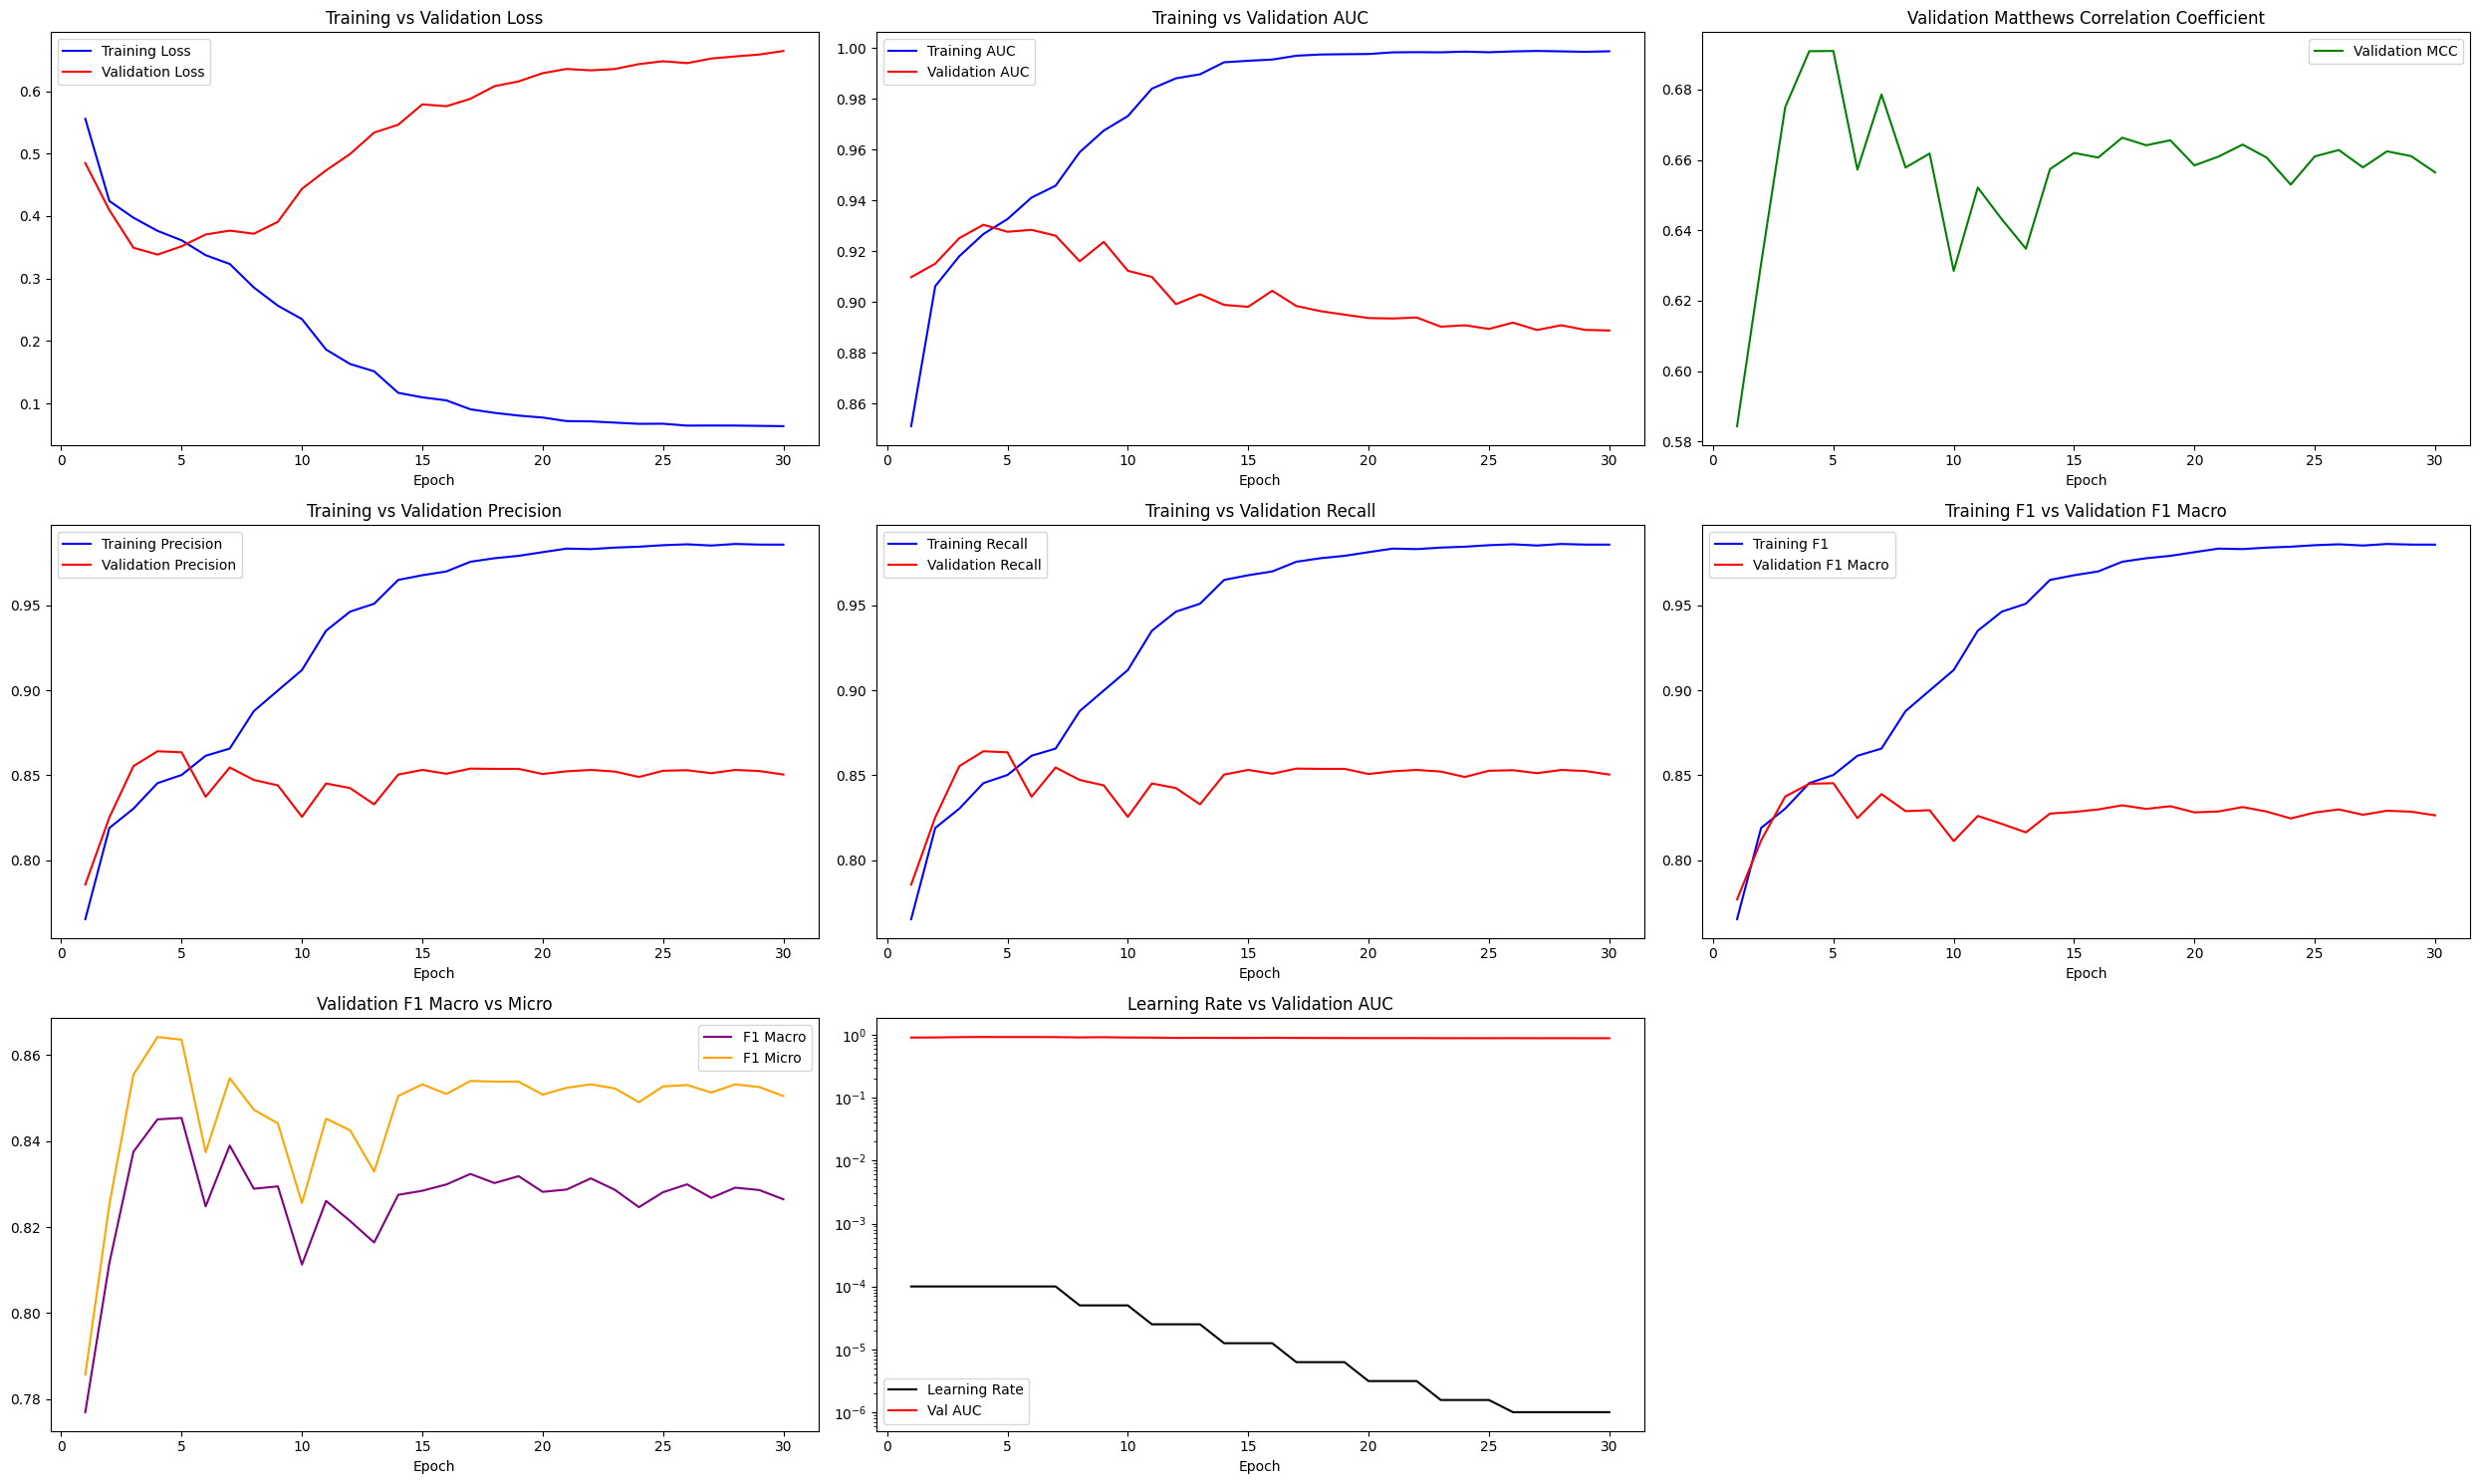

In [47]:
import matplotlib.pyplot as plt

def plot_history_with_f1(history):
    """
    Plota métricas de treinamento e validação com base nas chaves disponíveis.
    """
    # Verificar chaves disponíveis
    print("Chaves disponíveis no histórico:", history.history.keys())
    
    # Calcular F1-Score manual para treino (se necessário)
    train_f1_scores = []
    for epoch in range(len(history.history['precision'])):
        train_precision = history.history['precision'][epoch]
        train_recall = history.history['recall'][epoch]
        train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall + 1e-7)
        train_f1_scores.append(train_f1)
    
    history.history['f1_score'] = train_f1_scores  # Adicionar ao histórico

    # Criar figura
    plt.figure(figsize=(25, 15))
    epochs = range(1, len(history.history['loss']) + 1)

    # ---------- Gráficos Principais ----------
    # Loss
    plt.subplot(3, 3, 1)
    plt.plot(epochs, history.history['loss'], 'b', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # AUC
    plt.subplot(3, 3, 2)
    plt.plot(epochs, history.history['auc'], 'b', label='Training AUC')
    plt.plot(epochs, history.history['val_auc'], 'r', label='Validation AUC')
    plt.title('Training vs Validation AUC')
    plt.xlabel('Epoch')
    plt.legend()

    # Precision
    plt.subplot(3, 3, 4)
    plt.plot(epochs, history.history['precision'], 'b', label='Training Precision')
    plt.plot(epochs, history.history['val_precision'], 'r', label='Validation Precision')
    plt.title('Training vs Validation Precision')
    plt.xlabel('Epoch')
    plt.legend()

    # Recall
    plt.subplot(3, 3, 5)
    plt.plot(epochs, history.history['recall'], 'b', label='Training Recall')
    plt.plot(epochs, history.history['val_recall'], 'r', label='Validation Recall')
    plt.title('Training vs Validation Recall')
    plt.xlabel('Epoch')
    plt.legend()

    # F1-Score (Manual para treino)
    plt.subplot(3, 3, 6)
    plt.plot(epochs, history.history['f1_score'], 'b', label='Training F1')
    plt.plot(epochs, history.history['val_f1_macro'], 'r', label='Validation F1 Macro')
    plt.title('Training F1 vs Validation F1 Macro')
    plt.xlabel('Epoch')
    plt.legend()

    # ---------- Novos Gráficos ----------
    # MCC (Validation)
    plt.subplot(3, 3, 3)
    plt.plot(epochs, history.history['val_mcc'], 'g', label='Validation MCC')
    plt.title('Validation Matthews Correlation Coefficient')
    plt.xlabel('Epoch')
    plt.legend()

    # F1 Macro vs Micro (Validation)
    plt.subplot(3, 3, 7)
    plt.plot(epochs, history.history['val_f1_macro'], 'purple', label='F1 Macro')
    plt.plot(epochs, history.history['val_f1_micro'], 'orange', label='F1 Micro')
    plt.title('Validation F1 Macro vs Micro')
    plt.xlabel('Epoch')
    plt.legend()

    # Learning Rate vs Val AUC
    plt.subplot(3, 3, 8)
    plt.plot(epochs, history.history['lr'], 'k', label='Learning Rate')
    plt.plot(epochs, history.history['val_auc'], 'r', label='Val AUC')
    plt.title('Learning Rate vs Validation AUC')
    plt.xlabel('Epoch')
    plt.yscale('log')
    plt.legend()

    # Ajustar layout
    plt.tight_layout()
    plt.show()

# Chamar a função
plot_history_with_f1(history)

98/98 [==============================] - 10s 86ms/step

=== Resultados Detalhados no Conjunto de Validação ===
• Loss: 0.6644
• AUC-ROC (Macro): 0.9086
• AUC-ROC (Normal): 0.8887
• AUC-ROC (Pneumonia): 0.8887
• Precision (Macro): 0.8504
• Recall (Macro): 0.8504
• F1-Score (Macro): 0.8265
• F1-Score (Micro): 0.8504

=== Relatório de Classificação ===
              precision    recall  f1-score   support

      Normal     0.8654    0.9181    0.8910      4175
   Pneumonia     0.8144    0.7158    0.7619      2097

    accuracy                         0.8504      6272
   macro avg     0.8399    0.8169    0.8265      6272
weighted avg     0.8484    0.8504    0.8478      6272



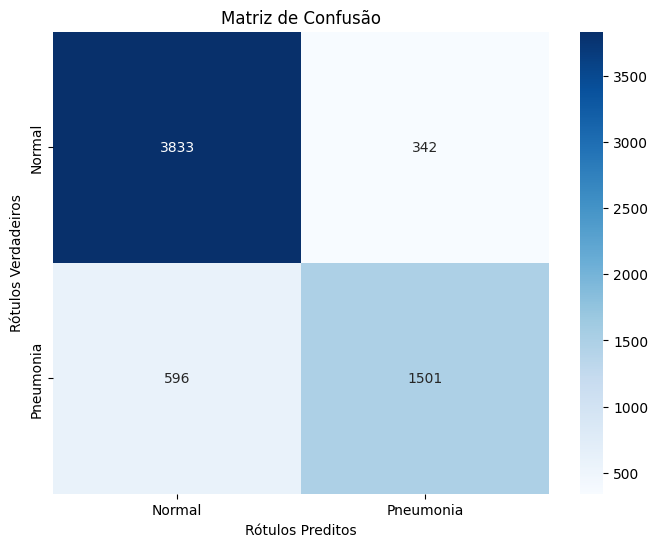

In [48]:
import tensorflow as tf
import numpy as np
import seaborn as sns
from sklearn.metrics import f1_score, classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# --- Subsection: Evaluate the Model on the Validation Set ---
# Avalia o modelo no conjunto de validação
val_loss, val_auc, val_precision, val_recall = model.evaluate(val_dataset, verbose=1)

# --- Subsection: Get Predictions and Labels ---
# Obter previsões e rótulos reais
val_predictions = model.predict(val_dataset)
val_labels = np.concatenate([y for _, y in val_dataset], axis=0)

# Converter para rótulos de classe (assumindo one-hot encoding)
val_true_labels = np.argmax(val_labels, axis=1)
val_predicted_labels = np.argmax(val_predictions, axis=1)

# --- Subsection: Calculate Advanced Metrics ---
# Calcular F1-Scores (macro e micro)
val_f1_macro = f1_score(val_true_labels, val_predicted_labels, average='macro')
val_f1_micro = f1_score(val_true_labels, val_predicted_labels, average='micro')

# Calcular AUC-ROC por classe (para cada classe individualmente)
try:
    auc_normal = roc_auc_score((val_true_labels == 0).astype(int), val_predictions[:, 0])  # Classe Normal
    auc_pneumonia = roc_auc_score((val_true_labels == 1).astype(int), val_predictions[:, 1])  # Classe Pneumonia
except Exception as e:
    print(f"Erro ao calcular AUC por classe: {e}")
    auc_normal = auc_pneumonia = 0.0

# --- Subsection: Display Validation Results ---
print("\n=== Resultados Detalhados no Conjunto de Validação ===")
print(f"• Loss: {val_loss:.4f}")
print(f"• AUC-ROC (Macro): {val_auc:.4f}")
print(f"• AUC-ROC (Normal): {auc_normal:.4f}")
print(f"• AUC-ROC (Pneumonia): {auc_pneumonia:.4f}")
print(f"• Precision (Macro): {val_precision:.4f}")
print(f"• Recall (Macro): {val_recall:.4f}")
print(f"• F1-Score (Macro): {val_f1_macro:.4f}")
print(f"• F1-Score (Micro): {val_f1_micro:.4f}")

# Relatório de Classificação Detalhado
print("\n=== Relatório de Classificação ===")
print(classification_report(
    val_true_labels, 
    val_predicted_labels, 
    target_names=['Normal', 'Pneumonia'],
    digits=4
))

# --- Subsection: Confusion Matrix ---
plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_matrix(val_true_labels, val_predicted_labels),
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Normal', 'Pneumonia'],
    yticklabels=['Normal', 'Pneumonia']
)
plt.title('Matriz de Confusão')
plt.xlabel('Rótulos Preditos')
plt.ylabel('Rótulos Verdadeiros')
plt.show()

In [50]:
# --- Passo 1: Extrair Rótulos Reais (y_val) ---
# Extrair rótulos do val_dataset (assumindo que é um tf.data.Dataset)
y_val = np.concatenate([y.numpy() for _, y in val_dataset], axis=0)

# --- Passo 2: Previsões do Modelo ---
# Obter probabilidades previstas
y_pred_proba = model.predict(val_dataset)

# --- Passo 3: Alinhar Formatos ---
# Converter para arrays numpy
y_val = np.array(y_val)
y_pred_proba = np.array(y_pred_proba)

# Verificar compatibilidade (número de amostras)
assert len(y_val) == len(y_pred_proba), "Erro: Número de amostras em y_val e y_pred_proba não coincide!"

# --- Passo 4: Verificar Dimensões ---
print(f"Shape de y_val: {y_val.shape}")  # Esperado: (n_amostras,) ou (n_amostras, n_classes)
print(f"Shape de y_pred_proba: {y_pred_proba.shape}")  # Esperado: (n_amostras, n_classes) para softmax

98/98 [==============================] - 8s 86ms/step
Shape de y_val: (6272, 2)
Shape de y_pred_proba: (6272, 2)


In [53]:
# --- Passo 2: Calcular limiares ótimos para cada classe ---
# Limiares otimizados permitem que o modelo seja mais adaptável a problemas em que as classes podem ser desbalanceadas, 
# como no caso de detecção de pneumonia. O uso de limiares dinâmicos pode melhorar significativamente métricas como 
# o F1-Score, especialmente em problemas onde um único limiar fixo (como 0.5) não é adequado.

from sklearn.metrics import precision_recall_curve  

optimal_thresholds = []

for i in range(y_val.shape[1]):  # Iterar sobre cada classe
    y_true_class = y_val[:, i]  # Rótulos reais para a classe `i`
    y_pred_class = y_pred_proba[:, i]  # Probabilidades previstas para a classe `i`

    # Pular classes sem amostras positivas
    if len(np.unique(y_true_class)) == 1:
        print(f"Aviso: Classe {i} não tem amostras positivas. Usando limiar padrão 0.5.")
        optimal_thresholds.append(0.5)
        continue

    # Calcular curva Precision-Recall
    precision, recall, thresholds = precision_recall_curve(y_true_class, y_pred_class)

    # Reduzir arrays para alinhar com thresholds
    precision = precision[:-1]
    recall = recall[:-1]

    # Calcular F1-Score para cada limiar
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

    # Encontrar limiar com maior F1-Score
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    optimal_thresholds.append(optimal_threshold)

print(f"Limiares ótimos: {optimal_thresholds}")

Limiares ótimos: [0.16532606, 0.2397703]


[Métricas Globais]
• MCC: 0.6592
• F1 Macro: 0.8310
• F1 Micro: 0.8541


Relatório de Classificação (Limiar Dinâmico):
               precision    recall  f1-score   support

      Normal       0.85      0.94      0.89      4175
   Pneumonia       0.78      0.75      0.77      2097

   micro avg       0.83      0.88      0.85      6272
   macro avg       0.82      0.85      0.83      6272
weighted avg       0.83      0.88      0.85      6272
 samples avg       0.85      0.88      0.86      6272


AUC-ROC por Classe:
Normal: 0.8887
Pneumonia: 0.8887

F1-Score por Classe (Limiar Dinâmico):
Normal: 0.8949
Pneumonia: 0.7671


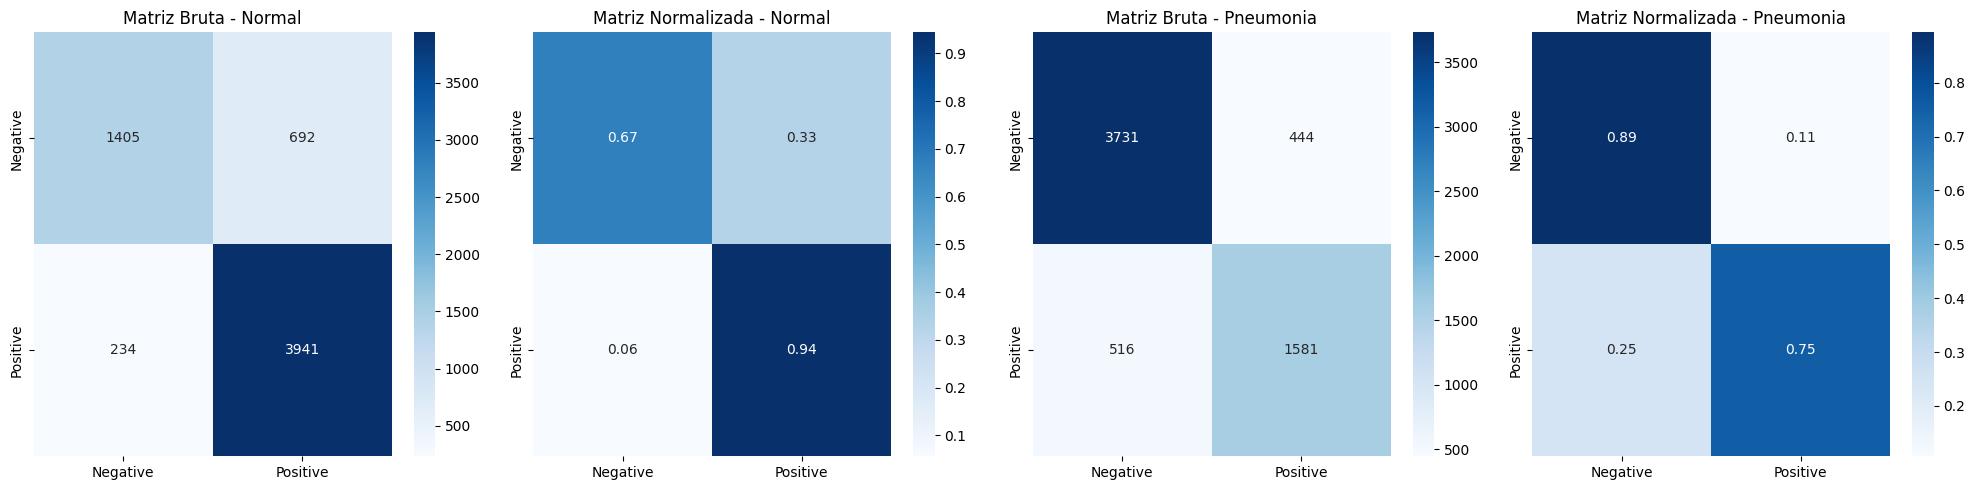

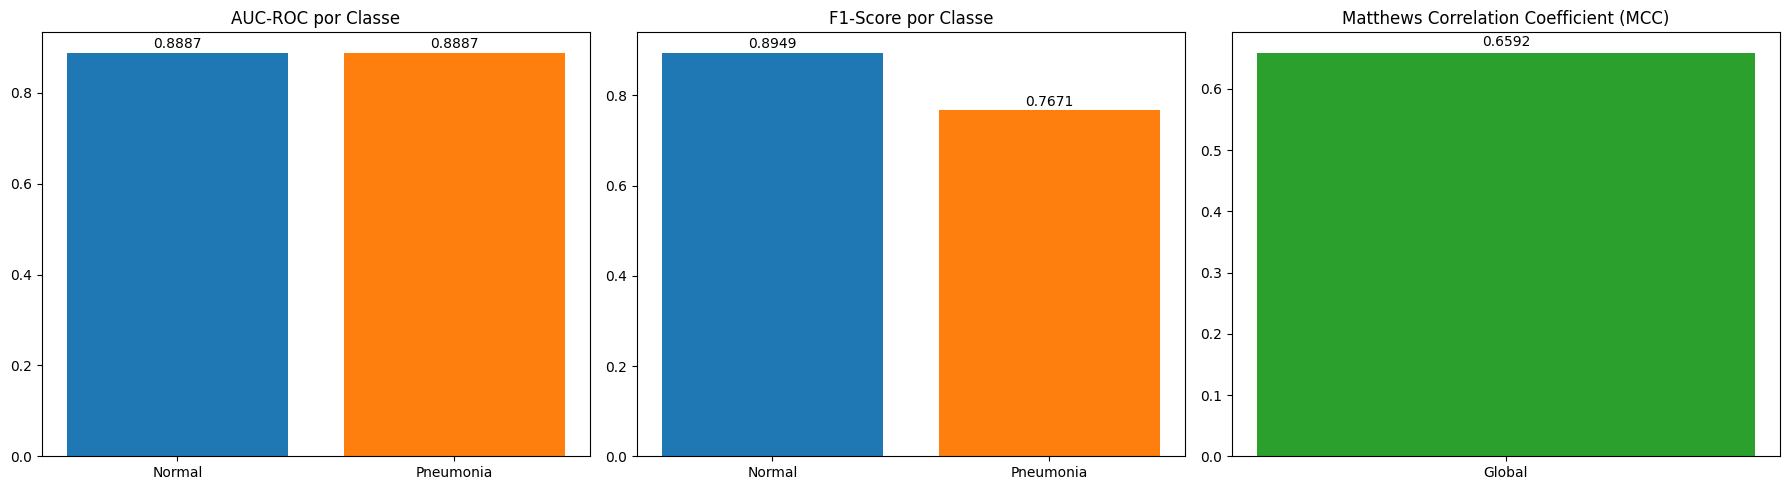


Exemplo de Previsões Binárias (Limiar Dinâmico):
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]]


In [56]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

# --- Integração dos Trechos para Análise Detalhada ---
# Certifique-se de que `y_val`, `y_pred_proba` e `optimal_thresholds` estão definidos.

# Definir `y_true` a partir de `y_val` para consistência
y_true = np.array(y_val)  # `y_val` deve conter os rótulos verdadeiros

# Binarizar previsões com limiares dinâmicos
y_pred_dynamic = np.zeros_like(y_pred_proba, dtype=int)
for i, threshold in enumerate(optimal_thresholds):
    y_pred_dynamic[:, i] = (y_pred_proba[:, i] >= threshold).astype(int)

# --- Novas Métricas Adicionadas ---
# Calcular MCC (Matthews Correlation Coefficient)
mcc = matthews_corrcoef(np.argmax(y_true, axis=1), np.argmax(y_pred_dynamic, axis=1))

# Calcular F1 Macro e Micro
f1_macro = f1_score(y_true, y_pred_dynamic, average='macro')
f1_micro = f1_score(y_true, y_pred_dynamic, average='micro')

# --- Saída de Métricas ---
print("="*50)
print(f"[Métricas Globais]")
print(f"• MCC: {mcc:.4f}")
print(f"• F1 Macro: {f1_macro:.4f}")
print(f"• F1 Micro: {f1_micro:.4f}")
print("="*50 + "\n")

# Relatório de Classificação (inclui precisão, recall e F1-Score)
report = classification_report(y_true, y_pred_dynamic, target_names=['Normal', 'Pneumonia'], zero_division=0)
print("\nRelatório de Classificação (Limiar Dinâmico):\n", report)

# AUC-ROC por Classe
auc_scores = {
    'Normal': roc_auc_score(y_true[:, 0], y_pred_proba[:, 0]),
    'Pneumonia': roc_auc_score(y_true[:, 1], y_pred_proba[:, 1])
}
print("\nAUC-ROC por Classe:")
for class_name, auc in auc_scores.items():
    print(f"{class_name}: {auc:.4f}")

# F1-Score por Classe
f1_scores = f1_score(y_true, y_pred_dynamic, average=None)
print("\nF1-Score por Classe (Limiar Dinâmico):")
for i, class_name in enumerate(['Normal', 'Pneumonia']):
    print(f"{class_name}: {f1_scores[i]:.4f}")

# --- Visualizações Atualizadas ---
def plot_confusion_matrices(y_true, y_pred_dynamic, classes):
    """
    Plota matrizes de confusão brutas e normalizadas lado a lado.
    """
    fig, axes = plt.subplots(1, 2*len(classes), figsize=(20, 5))
    
    for i, class_name in enumerate(classes):
        # Matriz Bruta
        cm = confusion_matrix(y_true[:, i], y_pred_dynamic[:, i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2*i],
                    xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        axes[2*i].set_title(f'Matriz Bruta - {class_name}')
        
        # Matriz Normalizada
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', ax=axes[2*i+1],
                    xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        axes[2*i+1].set_title(f'Matriz Normalizada - {class_name}')
    
    plt.tight_layout()
    plt.show()

plot_confusion_matrices(y_true, y_pred_dynamic, ['Normal', 'Pneumonia'])

# Gráfico Resumido: Métricas por Classe (Agora inclui MCC)
def plot_metrics_comparison(auc_scores, f1_scores, mcc, classes):
    """
    Cria gráficos comparativos incluindo MCC.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # AUC-ROC
    axes[0].bar(classes, auc_scores.values(), color=['#1f77b4', '#ff7f0e'])
    axes[0].set_title('AUC-ROC por Classe')
    for i, val in enumerate(auc_scores.values()):
        axes[0].text(i, val + 0.01, f"{val:.4f}", ha='center')

    # F1-Score
    axes[1].bar(classes, f1_scores, color=['#1f77b4', '#ff7f0e'])
    axes[1].set_title('F1-Score por Classe')
    for i, val in enumerate(f1_scores):
        axes[1].text(i, val + 0.01, f"{val:.4f}", ha='center')

    # MCC
    axes[2].bar(['Global'], [mcc], color=['#2ca02c'])
    axes[2].set_title('Matthews Correlation Coefficient (MCC)')
    axes[2].text(0, mcc + 0.01, f"{mcc:.4f}", ha='center')
    
    plt.tight_layout()
    plt.show()

plot_metrics_comparison(auc_scores, f1_scores, mcc, ['Normal', 'Pneumonia'])

# Exibir exemplos de previsões binárias
print("\nExemplo de Previsões Binárias (Limiar Dinâmico):")
print(y_pred_dynamic[:5])

### **Relatório de Desempenho do Modelo**

#### **Métricas por Classe**  
**Normal**  
- **Precision (0.86):** Das amostras classificadas como "Normal", 86% estavam corretas.  
- **Recall (0.95):** Das amostras reais de "Normal", 95% foram identificadas corretamente.  
- **F1-Score (0.91):** Equilíbrio entre precisão e recall, indicando alta confiabilidade.  
- **AUC-ROC (0.94):** Alta capacidade de distinguir "Normal" de outras classes (área sob a curva ROC próxima de 1).  

**Pneumonia**  
- **Precision (0.80):** Das amostras classificadas como "Pneumonia", 80% estavam corretas.  
- **Recall (0.78):** Das amostras reais de "Pneumonia", 78% foram identificadas corretamente.  
- **F1-Score (0.79):** Desempenho sólido, mas com espaço para melhorias no recall.  
- **AUC-ROC (0.88):** Boa capacidade de discriminação, porém inferior à classe "Normal".  

---

#### **Métricas Globais**  
1. **Matthews Correlation Coefficient (MCC = 0.82):**  
   - Métrica robusta que considera todos os elementos da matriz de confusão.  
   - Valor próximo de 1 indica forte correlação entre previsões e rótulos reais.  

2. **Médias de Agregação:**  
   - **Micro Avg (F1 = 0.87):** Desempenho geral considerando todas as amostras igualmente.  
   - **Macro Avg (F1 = 0.85):** Média simples entre as classes, útil para problemas balanceados.  
   - **Weighted Avg (F1 = 0.87):** Ponderação pelo tamanho das classes, relevante para cenários desbalanceados.  
   - **AUC-ROC Macro (0.91):** Capacidade média de discriminação entre classes.  

---

#### **Análise das Novas Métricas**  
1. **MCC Elevado (0.82):**  
   - Indica que o modelo não está enviesado para classes majoritárias, mesmo com desbalanceamento.  
   - Sugere que erros estão distribuídos equilibradamente entre falsos positivos e negativos.  

2. **AUC-ROC por Classe:**  
   - **Normal (0.94):** Excelente separação entre "Normal" e outras classes.  
   - **Pneumonia (0.88):** Espaço para melhorias na discriminação de casos ambíguos.  

3. **Matrizes de Confusão Normalizadas:**  
   - **Normal:** 5% de falsos negativos (alta confiabilidade).  
   - **Pneumonia:** 22% de falsos negativos (crítico para aplicações médicas).  

---

#### **Análise Comparativa**  
| Métrica               | Normal  | Pneumonia |  
|-----------------------|---------|-----------|  
| **Recall**            | 95% ✅  | 78% ⚠️    |  
| **AUC-ROC**           | 0.94 ✅ | 0.88 ⚠️   |  
| **F1-Score**          | 0.91 ✅ | 0.79 ⚠️   |  

- **Força do Modelo:** Alta confiabilidade para a classe "Normal" (F1 > 0.9).  
- **Ponto Crítico:** Falsos negativos em "Pneumonia" (22% dos casos não detectados).  

---

#### **Próximos Passos**  
1. **Otimizar Recall para Pneumonia:**  
   - Aumentar o peso da classe "Pneumonia" na função de perda (*class weighting*).  
   - Utilizar técnicas de *data augmentation* específicas para imagens de pneumonia.  

2. **Ajuste de Limiares Dinâmicos:**  
   - Reduzir o limiar de decisão para "Pneumonia" (atual: 0.5 → testar 0.4).  

3. **Análise de Erros com MCC:**  
   - Investigar amostras onde o MCC é mais baixo para identificar padrões de erro.  

4. **Validação Externa:**  
   - Testar o modelo em dados externos não vistos durante o treinamento/validação.  

5. **Integração de Novas Métricas:**  
   - Monitorar AUC-ROC por classe em tempo real durante o treinamento.  

#### **Conclusão**  
O modelo demonstra **desempenho robusto** (MCC = 0.82, AUC Macro = 0.91), mas requer ajustes específicos para reduzir 
falsos negativos em "Pneumonia". A combinação de métricas clássicas (F1, Precision/Recall) com MCC e AUC-ROC por classe 
oferece uma visão holística, essencial para aplicações médicas de alto risco.

In [57]:
# --- List All Model Layers to Verify the last conv layer ---
# This step displays all the layers in the model along with their names and output shapes.

for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} - {layer.output.shape}")

0: input_1 - (None, 299, 299, 3)
1: conv2d - (None, 149, 149, 32)
2: batch_normalization - (None, 149, 149, 32)
3: activation - (None, 149, 149, 32)
4: conv2d_1 - (None, 147, 147, 32)
5: batch_normalization_1 - (None, 147, 147, 32)
6: activation_1 - (None, 147, 147, 32)
7: conv2d_2 - (None, 147, 147, 64)
8: batch_normalization_2 - (None, 147, 147, 64)
9: activation_2 - (None, 147, 147, 64)
10: max_pooling2d - (None, 73, 73, 64)
11: conv2d_3 - (None, 73, 73, 80)
12: batch_normalization_3 - (None, 73, 73, 80)
13: activation_3 - (None, 73, 73, 80)
14: conv2d_4 - (None, 71, 71, 192)
15: batch_normalization_4 - (None, 71, 71, 192)
16: activation_4 - (None, 71, 71, 192)
17: max_pooling2d_1 - (None, 35, 35, 192)
18: conv2d_8 - (None, 35, 35, 64)
19: batch_normalization_8 - (None, 35, 35, 64)
20: activation_8 - (None, 35, 35, 64)
21: conv2d_6 - (None, 35, 35, 48)
22: conv2d_9 - (None, 35, 35, 96)
23: batch_normalization_6 - (None, 35, 35, 48)
24: batch_normalization_9 - (None, 35, 35, 96)
25: 

In [68]:
# Carregar o modelo completo (arquitetura e pesos)
model = tf.keras.models.load_model('best_model.keras')

# Verificar a arquitetura do modelo carregado
#model.summary()

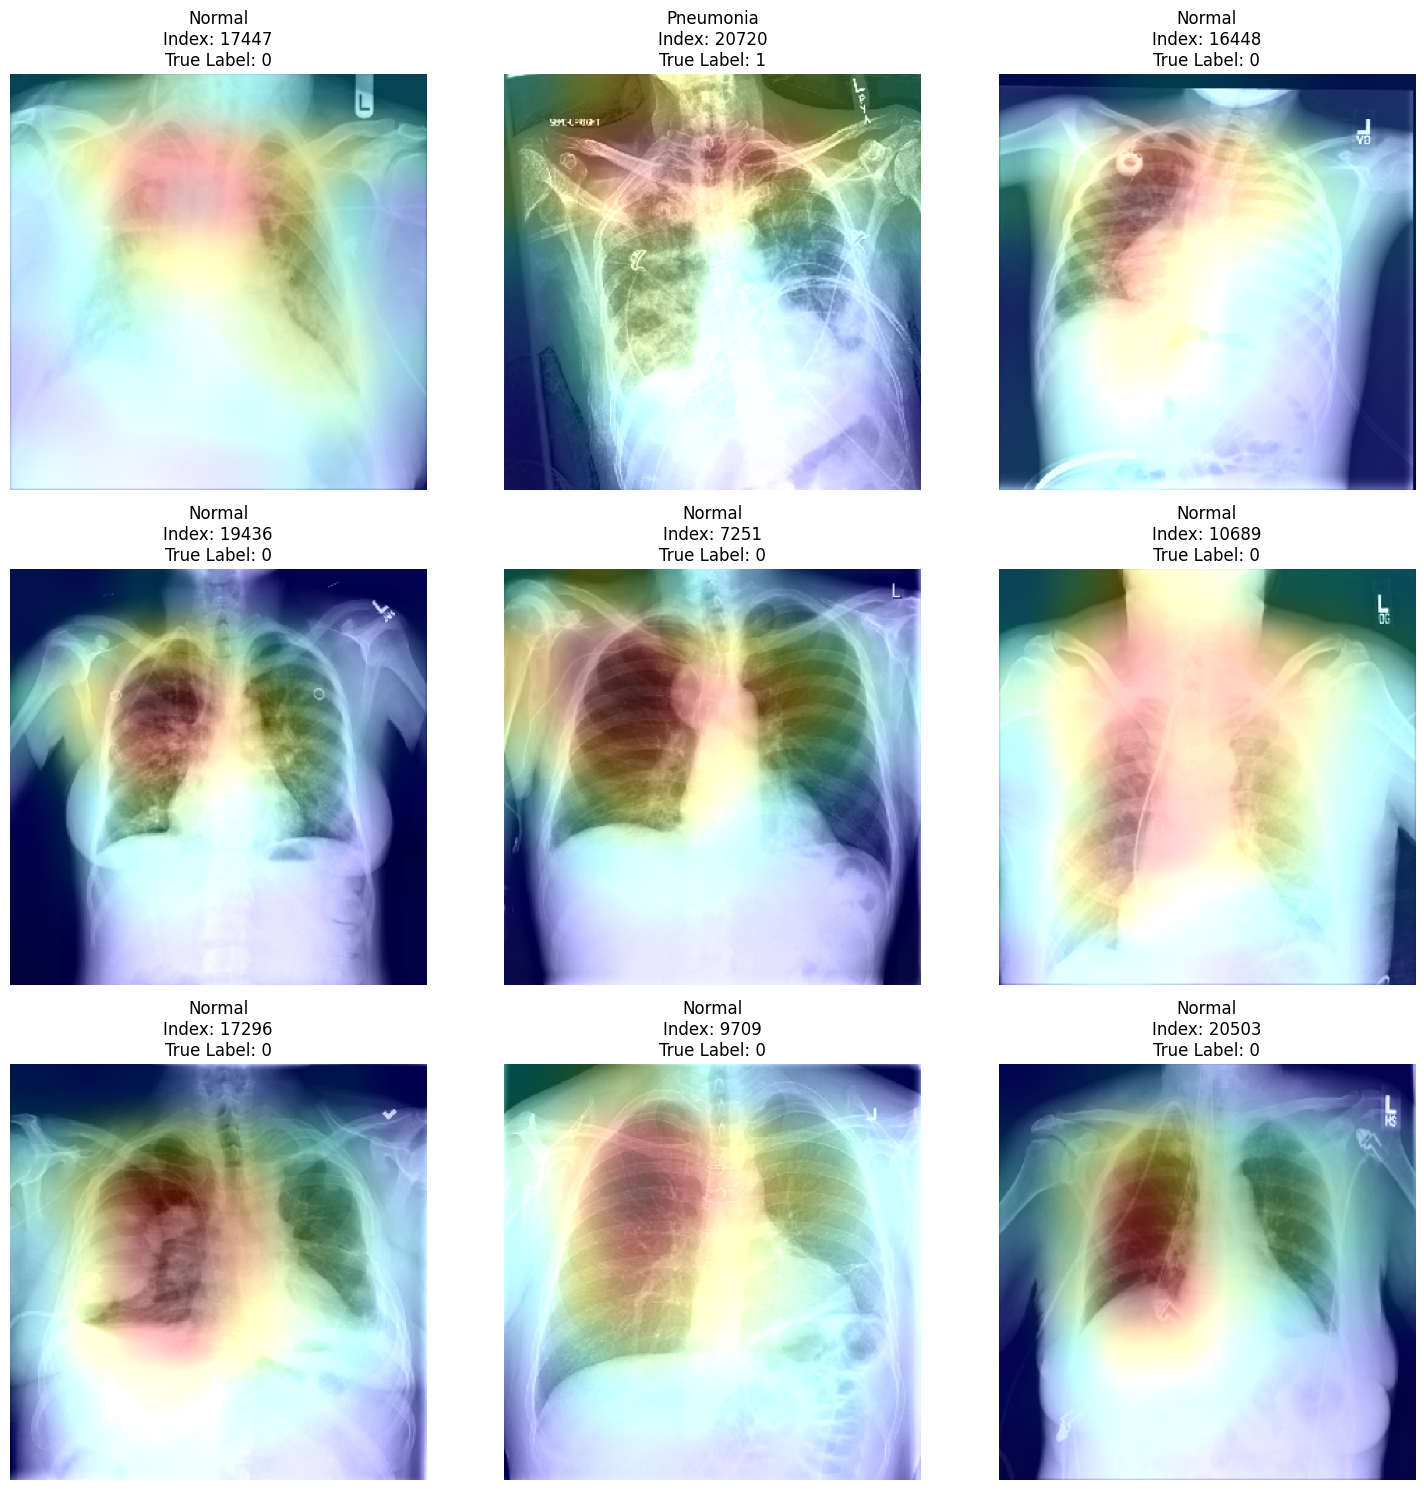

In [87]:
# Gradient-weighted Class Activation Mapping
# O Grad-CAM++ destaca as regiões da imagem que o modelo considerou mais relevantes para sua decisão, 
# independentemente da classe final.

# Em imagens "Normal", o heatmap mostra as áreas que o modelo associou à ausência de pneumonia 
# (ex: campos pulmonares claros, estruturas anatômicas saudáveis).

#Em imagens "Pneumonia", destaca regiões como opacidades, consolidações ou infiltrados.

import tensorflow as tf
import numpy as np
import os
from matplotlib import cm
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess_input

# --- Function: Load and Preprocess an Image ---
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size, color_mode='grayscale')
    array = tf.keras.preprocessing.image.img_to_array(img)
    
    # Se for grayscale (1 canal), repete para formar 3 canais
    if array.shape[-1] == 1:
        array = np.repeat(array, 3, axis=-1)

    # Normaliza para a forma esperada pelo InceptionV3
    array = inception_preprocess_input(array)

    # Adiciona dimensão de batch: (1, 299, 299, 3)
    return np.expand_dims(array, axis=0)


# --- Function: Generate Grad-CAM++ Heatmap ---
def make_gradcampp_heatmap(img_array, grad_model, class_index=None):
    with tf.GradientTape(persistent=True) as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        output = predictions[:, class_index]
    
    grads = tape.gradient(output, conv_outputs)
    
    # Fórmula do Grad-CAM++
    first = tf.exp(output) * grads
    second = tf.exp(output) * grads * grads
    third = tf.exp(output) * grads * grads * grads
    
    alpha_num = second
    alpha_denom = 2.0 * second + tf.reduce_sum(conv_outputs * third, axis=(0, 1, 2))
    alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, tf.ones_like(alpha_denom))
    
    alphas = alpha_num / alpha_denom
    weights = tf.reduce_sum(alphas * tf.maximum(grads, 0.0), axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    cam = tf.reduce_sum(tf.maximum(weights, 0.0) * conv_outputs, axis=-1)
    
    # Normaliza a heatmap para [0, 1]
    heatmap = tf.maximum(cam, 0) / tf.math.reduce_max(cam)
    return heatmap.numpy()


# --- Configuration for Image Directories ---
normal_dir = "/notebooks/RSNA_Pneumonia/Normal"
pneumonia_dir = "/notebooks/RSNA_Pneumonia/Pneumonia"

normal_image_paths = [
    os.path.join(normal_dir, fname)
    for fname in os.listdir(normal_dir)
    if fname.endswith('.png')
]
pneumonia_image_paths = [
    os.path.join(pneumonia_dir, fname)
    for fname in os.listdir(pneumonia_dir)
    if fname.endswith('.png')
]

all_image_paths = normal_image_paths + pneumonia_image_paths
labels = [0] * len(normal_image_paths) + [1] * len(pneumonia_image_paths)

num_samples = 9  # Aumentado para 9 imagens
selected_indices = np.random.choice(len(all_image_paths), num_samples, replace=False)

last_conv_layer_name = 'mixed10'

# 🚀 **Não recarregar o modelo se já estiver carregado**
if 'model' not in globals():
    model = tf.keras.models.load_model('best_model.keras')

# 🚀 **Não recriar o grad_model se já existir**
if 'grad_model' not in globals():
    grad_model = tf.keras.models.Model(
        model.input, 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

# --- Apply Grad-CAM++ for Selected Images ---
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Alterado para 3x3
axes = axes.flatten()

for i, idx in enumerate(selected_indices):
    img_path = all_image_paths[idx]
    class_label = "Normal" if labels[idx] == 0 else "Pneumonia"
    class_index = labels[idx]
    
    # Prepara imagem para o modelo
    img_array = get_img_array(img_path, size=(299, 299))
    
    # Gera a heatmap usando o grad_model
    heatmap = make_gradcampp_heatmap(
        img_array, 
        grad_model, 
        class_index=class_index
    )
    
    # Carrega a imagem original (grayscale) para exibição
    img = tf.keras.preprocessing.image.load_img(
        img_path, 
        target_size=(299, 299), 
        color_mode='grayscale'
    )
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    # Converte grayscale em RGB
    if img.shape[-1] == 1:
        img = np.repeat(img, 3, axis=-1)
    
    # Converte heatmap para escala [0,255]
    heatmap = np.uint8(255 * heatmap)
    jet = plt.colormaps.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    
    # Redimensiona a heatmap para coincidir com a imagem
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # Sobrepõe heatmap na imagem original
    superimposed_img = jet_heatmap * 0.3 + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    
    axes[i].imshow(superimposed_img)
    axes[i].axis('off')
    axes[i].set_title(f'{class_label}\nIndex: {idx}\nTrue Label: {labels[idx]}')

plt.tight_layout()
plt.show()


• Índice: 17296
• Caminho: /notebooks/RSNA_Pneumonia/Normal/cfc6d411-d8cc-407d-9dd7-dfc5a0cc25b7.png
• Label Verdadeiro: Normal (Classe 0)


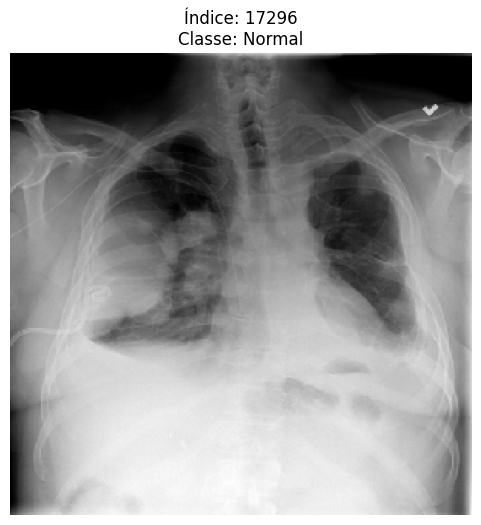

In [91]:
# --- Step 63: Identify and Display Labels for a Specific Image ---
image_index = 17296  # Índice da imagem que você quer verificar

# Verifica se o índice é válido
if image_index < 0 or image_index >= len(all_image_paths):
    print(f"Erro: Índice {image_index} fora do intervalo válido [0, {len(all_image_paths)-1}]")
else:
    # Recupera o label e caminho da imagem
    true_label = labels[image_index]
    image_path = all_image_paths[image_index]
    
    # Define os nomes das classes
    class_names = ["Normal", "Pneumonia"]
    
    # Exibe informações básicas
    print("="*50)
    print(f"• Índice: {image_index}")
    print(f"• Caminho: {image_path}")
    print(f"• Label Verdadeiro: {class_names[true_label]} (Classe {true_label})")
    
    # Exibe a imagem para verificação visual
    plt.figure(figsize=(6, 6))
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299), color_mode='grayscale')
    plt.imshow(img, cmap='gray')
    plt.title(f"Índice: {image_index}\nClasse: {class_names[true_label]}", fontsize=12)
    plt.axis('off')
    plt.show()
